# Model#3
<img src="Model3.png" width="800">

## Cell OCV curve

In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
from scipy import special
import time
import matplotlib.cm as cm
from sklearn.linear_model import LinearRegression

In [2]:
%config InlineBackend.figure_formats = {'png', 'retina'}
pd.set_option("display.max_rows", 10)

In [3]:
def DOD_norm(df, dod_s, dod_e):
    df = df - np.min(df)
    b = (dod_e - dod_s)/np.max(df)
    df = df*b
    df = df + dod_s
    return df

In [4]:
def DOD_norm2(df, x_s, x_e):
    return (df - x_s) * 100/(x_e - x_s)

In [5]:
def re_DOD_norm2(df, x_s, x_e):
    return df*(x_e - x_s)/100 +  x_s

In [6]:
def dQdV(df_x, df_y, delta):
    dQ = abs(np.roll(df_x, delta) - np.roll(df_x, -delta))
    dV = abs(np.roll(df_y, delta) - np.roll(df_y, -delta))
    dQ = np.where(dQ <=0, np.nan, dQ)
    df_dQdV = dV/dQ
    df_dQdV[:delta] = np.nan
    df_dQdV[-delta:] = np.nan
    return df_dQdV

In [7]:
def smooth(df, delta):
    df_tmp = np.zeros((2*delta, len(df)))
    for i in range(delta):
        df_tmp[(i-1),:] = np.roll(df, i)
        df_tmp[(i-1+delta),:] = np.roll(df, -i)
    df_tmp2 = np.median(df_tmp, axis=0)
    df_tmp2[:delta] = np.nan
    df_tmp2[-delta:] = np.nan
    
    return df_tmp2

In [8]:
new_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

In [9]:
df_LCO_OCV = pd.read_csv('LCO_OCV1.csv')
df_LCO_OCV.columns = ['x', 'Potential(V)']
df_LCO_OCV = df_LCO_OCV.sort_values(by=['x'], ascending=False)
df_LCO_OCV = df_LCO_OCV.reset_index(drop=True)
df_LCO_OCV['x'] = 1-df_LCO_OCV['x']

df_LCO_OCV['x'] = smooth(df_LCO_OCV['x'],20)
df_LCO_OCV['Potential(V)'] = smooth(df_LCO_OCV['Potential(V)'], 20)
df_LCO_OCV = df_LCO_OCV.dropna()
df_LCO_OCV = df_LCO_OCV.sort_values(by=['x'], ascending=True)

In [10]:
df_LiC6_OCV = pd.read_csv('LiC6_OCV1.csv')
df_LiC6_OCV.columns = ['x', 'Potential(V)']
df_LiC6_OCV = df_LiC6_OCV.sort_values(by=['x'], ascending=False)
df_LiC6_OCV = df_LiC6_OCV.reset_index(drop=True)
df_LiC6_OCV['x'] = 1-df_LiC6_OCV['x']
df_LiC6_OCV['x'] = smooth(df_LiC6_OCV['x'],10)
df_LiC6_OCV['Potential(V)'] = smooth(df_LiC6_OCV['Potential(V)'], 10)
df_LiC6_OCV = df_LiC6_OCV.dropna()
df_LiC6_OCV = df_LiC6_OCV.sort_values(by=['x'], ascending=True)

In [11]:
x_p_s = 0.2
x_p_e = 0.95
x_n_s = 0.17
x_n_e = 0.94

df_LCO_OCV['DOD']  = DOD_norm2(df_LCO_OCV['x'], x_p_s, x_p_e)
df_LiC6_OCV['DOD']  = DOD_norm2(df_LiC6_OCV['x'], x_n_s, x_n_e)

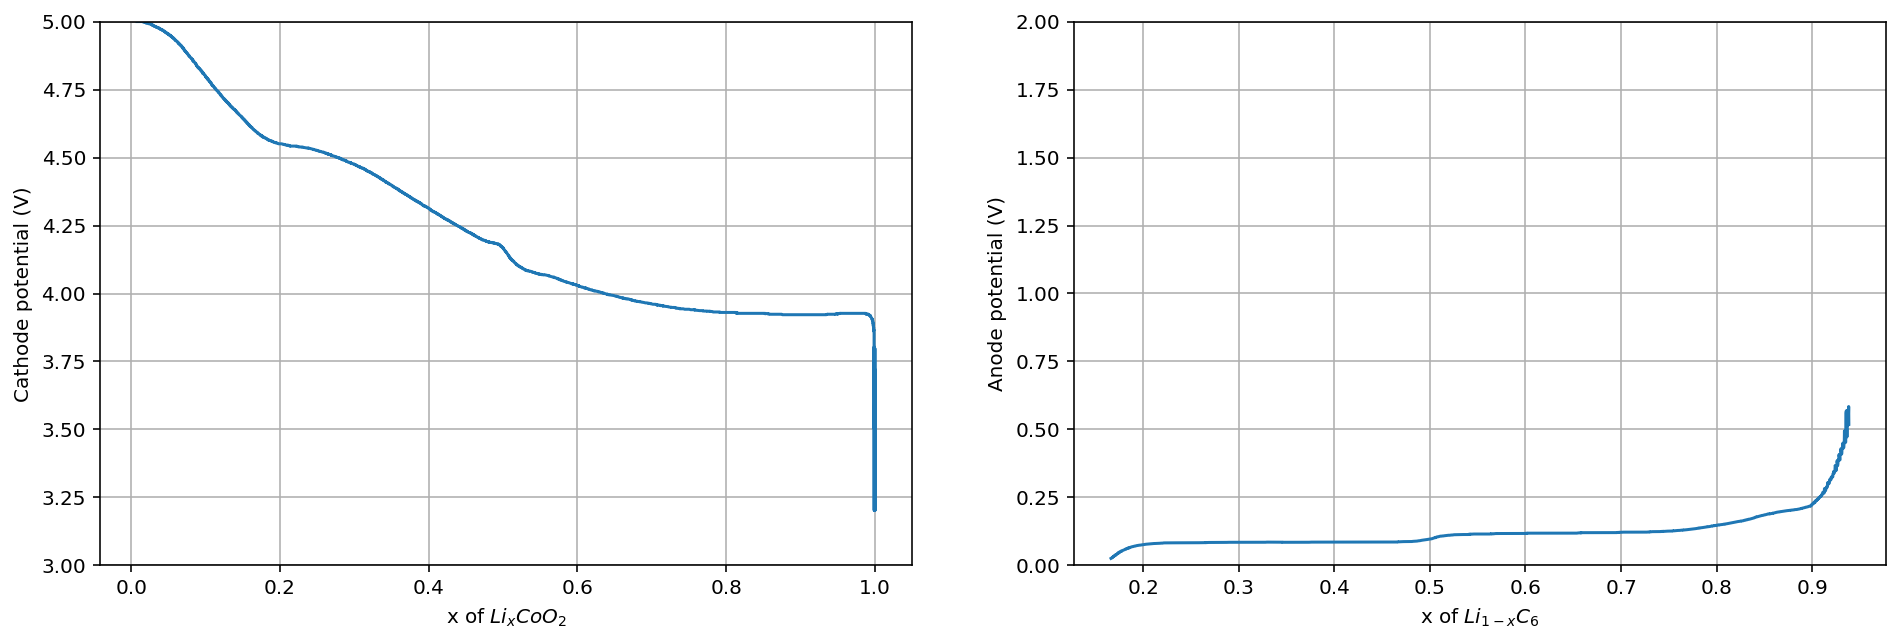

In [12]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16, 5))

ax1.plot(df_LCO_OCV['x'], df_LCO_OCV['Potential(V)'])
ax1.set_ylim([3, 5])
ax1.set_ylabel('Cathode potential (V)')
ax1.set_xlabel('x of $Li_{x}CoO_2$')
ax1.grid()

ax2.plot(df_LiC6_OCV['x'], df_LiC6_OCV['Potential(V)'])
ax2.set_ylim([0, 2])
ax2.set_ylabel('Anode potential (V)')
ax2.set_xlabel('x of $Li_{1-x}C_6$')
ax2.grid()
plt.show()

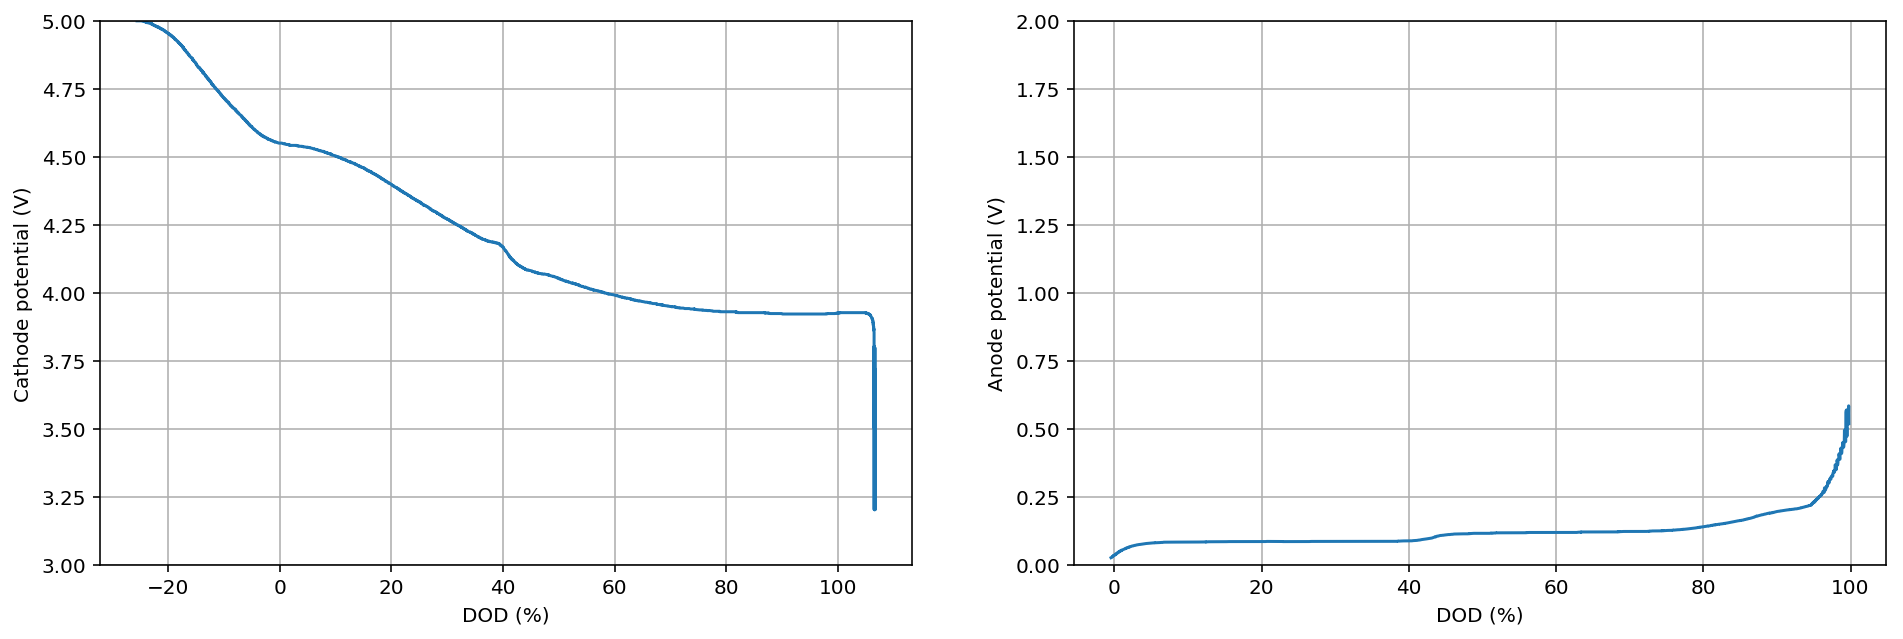

In [13]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16, 5))

ax1.plot(df_LCO_OCV['DOD'], df_LCO_OCV['Potential(V)'])
ax1.set_ylim([3, 5])
ax1.set_ylabel('Cathode potential (V)')
ax1.set_xlabel('DOD (%)')
ax1.grid()

ax2.plot(df_LiC6_OCV['DOD'], df_LiC6_OCV['Potential(V)'])
ax2.set_ylim([0, 2])
ax2.set_ylabel('Anode potential (V)')
ax2.set_xlabel('DOD (%)')
ax2.grid()
plt.show()

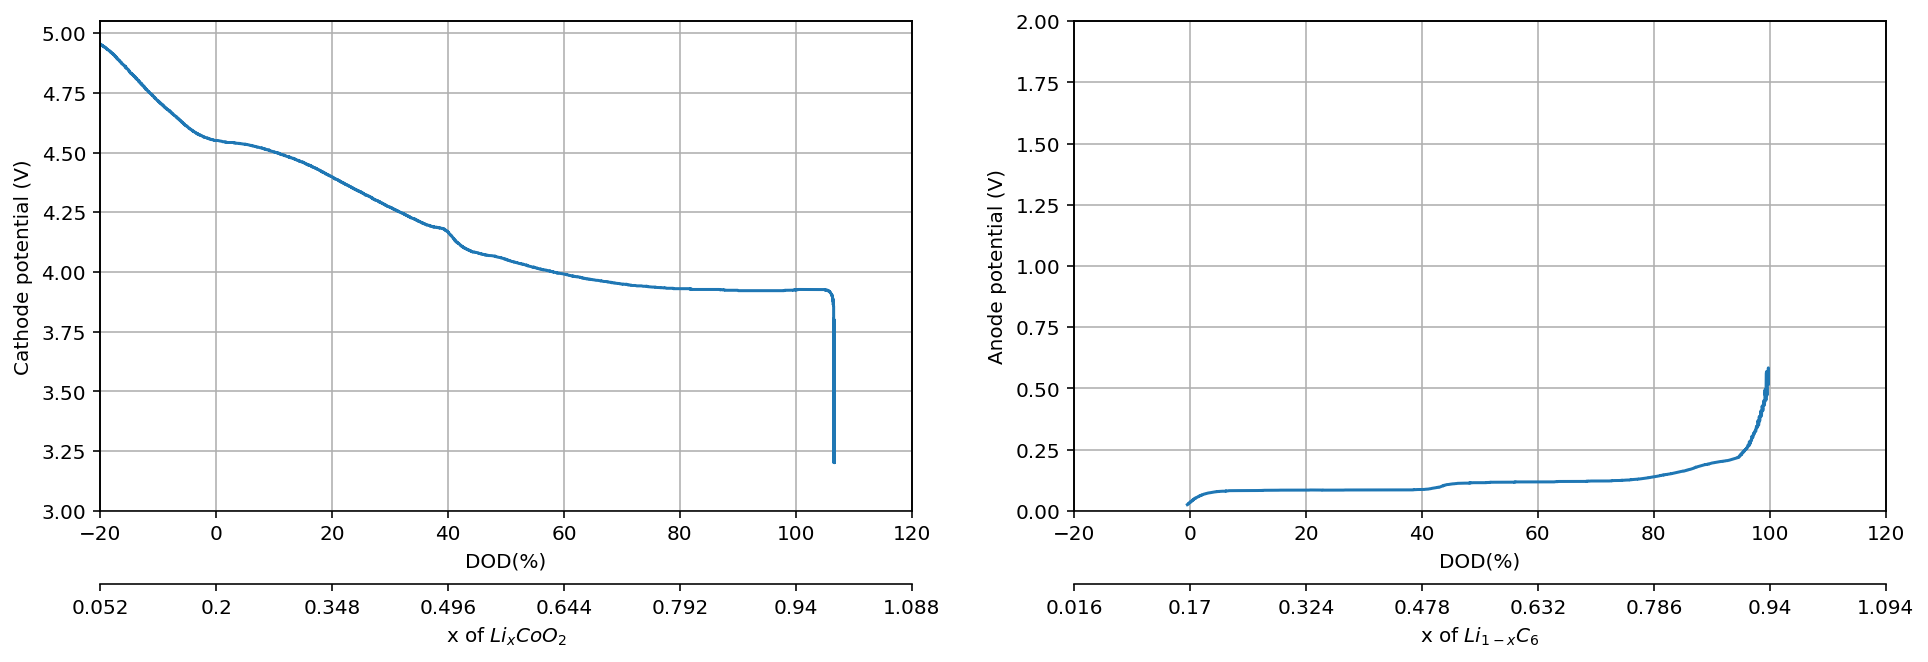

In [14]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16, 5))

fig.subplots_adjust(bottom=0.2)
ax1.plot(df_LCO_OCV['DOD'], df_LCO_OCV['Potential(V)'])
ax1.set_ylim([3, 5.05])
ax1.set_xlim([-20,120])
ax1.set_ylabel('Cathode potential (V)')
ax1.set_xlabel('DOD(%)')
ax1.grid()

ax3 = ax1.twiny()
ax3.xaxis.set_ticks_position("bottom")
ax3.xaxis.set_label_position("bottom")
ax3.spines["bottom"].set_position(("axes", -0.15))

ax3.set_frame_on(True)
ax3.patch.set_visible(False)
ax3.spines["bottom"].set_visible(True)
ax3.set_xticks([-20,0,20,40,60,80,100,120])
ax3.set_xticklabels(re_DOD_norm2(np.array([-20,0,20,40,60,80,100,120]), x_p_s, x_n_e))
ax3.set_xlabel("x of $Li_{x}CoO_2$")


ax2.plot(df_LiC6_OCV['DOD'], df_LiC6_OCV['Potential(V)'])
ax2.set_ylim([0, 2])
ax2.set_xlim([-20,120])
ax2.set_ylabel('Anode potential (V)')
ax2.set_xlabel('DOD(%)')
ax2.grid()

ax4 = ax2.twiny()
ax4.xaxis.set_ticks_position("bottom")
ax4.xaxis.set_label_position("bottom")
ax4.spines["bottom"].set_position(("axes", -0.15))
ax4.set_frame_on(True)
ax4.patch.set_visible(False)
ax4.spines["bottom"].set_visible(True)
ax4.set_xticks([-20,0,20,40,60,80,100,120])
ax4.set_xticklabels(re_DOD_norm2(np.array([-20,0,20,40,60,80,100,120]), x_n_s, x_n_e))
ax4.set_xlabel("x of $Li_{1-x}C_6$")



plt.show()

In [15]:
df_cell = pd.DataFrame(np.arange(1001))/10
df_cell.columns = ['DOD']
df_cell = pd.merge_asof(df_cell, df_LCO_OCV, on='DOD', direction='nearest')
df_cell = pd.merge_asof(df_cell, df_LiC6_OCV, on='DOD', direction='nearest')
df_cell.columns = ['DOD', 'Cathode x (-)', 'Cathode OCV (V)', 'Anode x (-)', 'Anode OCV (V)']
df_cell['Cell OCV (V)'] = (df_cell['Cathode OCV (V)']  - df_cell['Anode OCV (V)'] )
df_cell

,DOD,Cathode x (-),Cathode OCV (V),Anode x (-),Anode OCV (V),Cell OCV (V)
0,0.0,0.20032,4.550720,0.169631,0.034329,4.516391
1,0.1,0.20040,4.550720,0.170686,0.036918,4.513802
2,0.2,0.20132,4.550720,0.171753,0.039765,4.510955
3,0.3,0.20241,4.550720,0.172365,0.039610,4.511110
4,0.4,0.20341,4.549880,0.173068,0.042250,4.507630
...,...,...,...,...,...,...
996,99.6,0.94686,3.923630,0.936868,0.515807,3.407823
997,99.7,0.94786,3.924890,0.937583,0.515807,3.409083
998,99.8,0.94887,3.924050,0.938267,0.518913,3.405137
999,99.9,0.94887,3.924890,0.938267,0.518913,3.405977


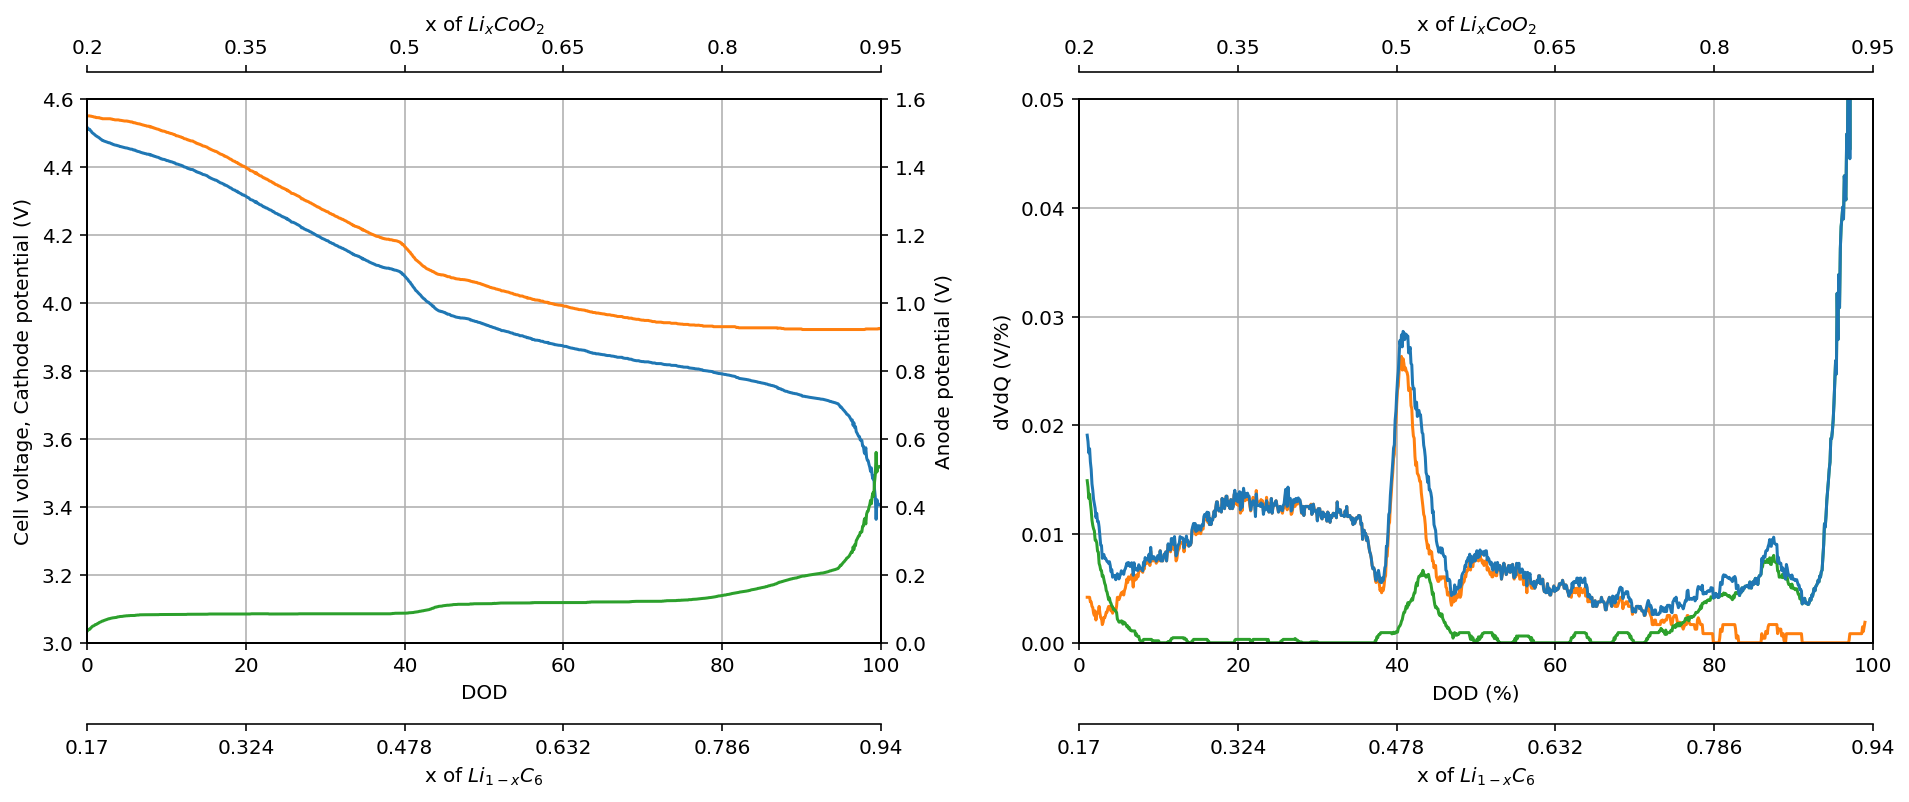

In [16]:
fig, (ax1,ax3) = plt.subplots(1,2,figsize=(16, 5))
plt.subplots_adjust(wspace=0.25)
ax2 = ax1.twinx()
ax1.plot(df_cell['DOD'], df_cell['Cathode OCV (V)'], color = new_colors[1])
ax1.plot(df_cell['DOD'], df_cell['Cell OCV (V)'], color = new_colors[0])
ax1.set_ylabel('Cell voltage, Cathode potential (V)')
ax2.plot(df_cell['DOD'], df_cell['Anode OCV (V)'], color = new_colors[2])
ax2.set_ylabel('Anode potential (V)')
ax1.set_xlabel('DOD')

ax1.set_ylim([3, 4.6])
ax2.set_ylim([0, 1.6])
ax1.grid()

ax1.set_xlim([0,100])
ax4 = ax1.twiny()
ax4.xaxis.set_ticks_position("bottom")
ax4.xaxis.set_label_position("bottom")
ax4.spines["bottom"].set_position(("axes", -0.15))

ax4.set_frame_on(True)
ax4.patch.set_visible(False)
ax4.spines["bottom"].set_visible(True)
ax4.set_xticks([0,20,40,60,80,100])
ax4.set_xticklabels(re_DOD_norm2(np.array([0,20,40,60,80,100]), x_n_s, x_n_e))
ax4.set_xlabel("x of $Li_{1-x}C_6$")


ax5 = ax1.twiny()
ax5.xaxis.set_ticks_position("top")
ax5.xaxis.set_label_position("top")
ax5.spines["top"].set_position(("axes", +1.05))

ax5.set_frame_on(True)
ax5.patch.set_visible(False)
ax5.spines["top"].set_visible(True)
ax5.set_xticks([0,20,40,60,80,100])
ax5.set_xticklabels(re_DOD_norm2(np.array([0,20,40,60,80,100]), x_p_s, x_p_e))
ax5.set_xlabel("x of $Li_{x}CoO_2$")



ax3.plot(df_cell['DOD'], dQdV(df_cell['DOD'], df_cell['Cathode OCV (V)'], 10), color = new_colors[1])
ax3.plot(df_cell['DOD'], dQdV(df_cell['DOD'], df_cell['Anode OCV (V)'], 10), color = new_colors[2])
ax3.plot(df_cell['DOD'], dQdV(df_cell['DOD'], df_cell['Cell OCV (V)'], 10), color = new_colors[0])


ax3.set_ylabel('dVdQ (V/%)')
ax3.set_xlabel('DOD (%)')

ax3.set_ylim([0, 0.05])
ax3.grid(which='both')

ax3.set_xlim([0,100])
ax6 = ax3.twiny()
ax6.xaxis.set_ticks_position("bottom")
ax6.xaxis.set_label_position("bottom")
ax6.spines["bottom"].set_position(("axes", -0.15))

ax6.set_frame_on(True)
ax6.patch.set_visible(False)
ax6.spines["bottom"].set_visible(True)
ax6.set_xticks([0,20,40,60,80,100])
ax6.set_xticklabels(re_DOD_norm2(np.array([0,20,40,60,80,100]), x_n_s, x_n_e))
ax6.set_xlabel("x of $Li_{1-x}C_6$")


ax7 = ax3.twiny()
ax7.xaxis.set_ticks_position("top")
ax7.xaxis.set_label_position("top")
ax7.spines["top"].set_position(("axes", +1.05))

ax7.set_frame_on(True)
ax7.patch.set_visible(False)
ax7.spines["top"].set_visible(True)
ax7.set_xticks([0,20,40,60,80,100])
ax7.set_xticklabels(re_DOD_norm2(np.array([0,20,40,60,80,100]), x_p_s, x_p_e))
ax7.set_xlabel("x of $Li_{x}CoO_2$")


plt.show()


In [83]:
# Anode thickness
N_length = ((max(df_cell['Cathode x (-)']) - min(df_cell['Cathode x (-)']))*C_s_max_p*S*P_length*F)/((max(df_cell['Anode x (-)']) - min(df_cell['Anode x (-)']))*C_s_max_n*S*F)
N_length

0.00014476100375610592

## Diffuion

Fick'S second law
\begin{eqnarray*}
\frac{\partial C_s(x,t)}{\partial t} = D_s\frac{\partial^2 C_s(x,t)}{\partial x^2}
\end{eqnarray*}
Boundary condition and initial condition
\begin{eqnarray*}
\frac{\partial C_s(x=0,t)}{\partial t} = 0\\
\frac{\partial C_s(x=R_s,t)}{\partial t} = j(t)\\
C_s(x,t=0)=C_{s,0}
\end{eqnarray*}

In [191]:
#Temperature
T = 298#[K]
temp_0 = 23 + 273.15#[K]

#Cathode Dimension
L1 = 100E-6 #[m]
L2 = 200E-6 #[m]

Al_length = L1
P_length = L2-L1

#Electrolyte Dimension
L3 = 300E-6 #[m]


#Anode Dimension
N_length = ((max(df_cell['Cathode x (-)']) - min(df_cell['Cathode x (-)']))*C_s_max_p*S*P_length*F)/((max(df_cell['Anode x (-)']) - min(df_cell['Anode x (-)']))*C_s_max_n*S*F)
Cu_length = 100E-6 #[m]

L4 = L3 + N_length #[m]
L5 = L4 + Cu_length #[m]

#Area Dimension
M = 100E-6 #[m]
N = 100E-6 #[m]
S = M * N#[m2]

#Current
I = 6.4E-7#[A = C/sec]
j = I/S*0.1#(0.1ItA)[A/m2 = C/sec m2]

# Charge or Discharge
Condition = 'Charge'
if Condition == 'Discharge':
    j = abs(j)*(-1)

#Constant
R = 8.3144598 #[J/(mol K)]
F = 96485.33289 #[C/mol]
z = 1
alpha=0.5

k_o_p = 2.344E-11#7.13E-8
k_o_n = 5.0307E-11#1.47E-7
C_e = 1000#[mol/m3]
C_s_max_p = 2.39E4 #[mol/m3]
C_s_max_n = 1.61E4 #[mol/m3]
C_s_p_0 = C_s_max_p*df_cell['Cathode x (-)'][0]
C_s_n_0 = C_s_max_n*(1 - df_cell['Anode x (-)'][0])


#Diffusion coefficient
D_p = 1.0E-12 #[m2/s]
D_n = 2.0E-12 #[m2/s]



In [419]:
# Memo
# C = C/sec sec = A sec
# C*60*60 = Ah

In [423]:
# Cathode capacity
print((max(df_cell['Cathode x (-)']) - min(df_cell['Cathode x (-)']))*C_s_max_p*S*P_length*F) # [C]
print((max(df_cell['Cathode x (-)']) - min(df_cell['Cathode x (-)']))*C_s_max_p*S*P_length*F/3600) # [C/sec * sec /36000 = A sec /36000 =Ah ]
Full_cap = (max(df_cell['Cathode x (-)']) - min(df_cell['Cathode x (-)']))*C_s_max_p*S*P_length*F/3600 #Ah

0.0017284618923
4.80128303416e-07


In [421]:
# Anode capacity
print((max(df_cell['Anode x (-)']) - min(df_cell['Anode x (-)']))*C_s_max_n*S*N_length*F) # [C]
print((max(df_cell['Anode x (-)']) - min(df_cell['Anode x (-)']))*C_s_max_n*S*N_length*F/3600) # [C/sec * sec /36000 = A sec /36000 =Ah ]

0.0017284618923
4.80128303416e-07


In [300]:
t1 = time.time()
# Number of partitions of rod (finite elements)
n = 10
dx = P_length/n

t_total = 60*60*10 #[sec] run time
dt = 0.5 #[sec] Time partitions
t_total +=dt
# Make an array with positions of middle of each partition
x = np.linspace(dx/2, P_length - dx/2,n)

# Initialize rod to initial temperature distribution.
C = np.ones(len(x))*C_s_p_0*S
dCdt = np.empty(n)

t = np.arange(0,t_total,dt)

time_rlt = np.zeros(len(t))
x_rlt = np.zeros((len(t),len(x)))
C_rlt = np.zeros((len(t),len(C)))

for jj in range(1,len(t)+1):
    for i in range(1,n-1):

        # Applying discrete definition of second derivative
        dCdt[i] = D_p*((C[i+1] - C[i])/dx - (C[i] - C[i-1])/dx)/dx
        
    # Taking into account boundary condition. ie. T[0-1] DNE
    dCdt[0] = D_p*((C[1] - C[0])/dx)/dx
    dCdt[n-1] = D_p*(j*S/F/D_p - (C[n-1] - C[n-2])/dx)/dx
    
    # Update temperature data for rod
    C = C + dCdt * dt

    time_rlt[jj-1] = (jj-1)*dt
    x_rlt[jj-1] = x #
    C_rlt[jj-1] = C #concentration per dx
    if jj % divmod(len(t), 10)[0] == 0:
        print('{}'.format(jj/(len(t)-1)*100),'% processed ')

t2 = time.time()
print('{:.2}'.format(t2-t1),'sec')

10.0 % processed 
20.0 % processed 
30.0 % processed 
40.0 % processed 
50.0 % processed 
60.0 % processed 
70.0 % processed 
80.0 % processed 
90.0 % processed 
100.0 % processed 
1.2 sec


In [340]:
len(np.zeros((len(t)+1,len(x))))

72002

In [452]:
t1 = time.time()
# Number of partitions of rod (finite elements)
n = 10
dx = P_length/n

t_total = 60*60*10 #[sec] run time
dt = 0.5 #[sec] Time partitions
t_total +=dt
# Make an array with positions of middle of each partition
x = np.linspace(dx/2, P_length - dx/2,n)

# Initialize rod to initial temperature distribution.
C = np.ones(len(x))*C_s_p_0*S
dCdt = np.empty(n)

t = np.arange(0,t_total,dt)

time_rlt = np.zeros((len(t)+1))
x_rlt = np.zeros((len(t)+1,len(x)))
C_rlt = np.zeros((len(t)+1,len(C)))
x_rlt[0] = x
C_rlt[0] = C

for jj in range(1,len(t)+1):
    for i in range(1,n-1):

        # Applying discrete definition of second derivative
        dCdt[i] = D_p*((C[i+1] - C[i])/dx - (C[i] - C[i-1])/dx)/dx
        
    # Taking into account boundary condition. ie. T[0-1] DNE
    dCdt[0] = D_p*((C[1] - C[0])/dx)/dx
    dCdt[n-1] = D_p*(j*S/F/D_p - (C[n-1] - C[n-2])/dx)/dx
    
    # Update temperature data for rod
    C = C + dCdt * dt

    time_rlt[jj] = (jj)*dt
    x_rlt[jj] = x #
    C_rlt[jj] = C #concentration per dx
    if jj % divmod(len(t), 10)[0] == 0:
        print('{}'.format(jj/(len(t)-1)*100),'% processed ')

t2 = time.time()
print('{:.2}'.format(t2-t1),'sec')

10.0 % processed 
20.0 % processed 
30.0 % processed 
40.0 % processed 
50.0 % processed 
60.0 % processed 
70.0 % processed 
80.0 % processed 
90.0 % processed 
100.0 % processed 
1.0 sec


In [453]:
(C_rlt[0,:])

array([  4.78764800e-05,   4.78764800e-05,   4.78764800e-05,
         4.78764800e-05,   4.78764800e-05,   4.78764800e-05,
         4.78764800e-05,   4.78764800e-05,   4.78764800e-05,
         4.78764800e-05])

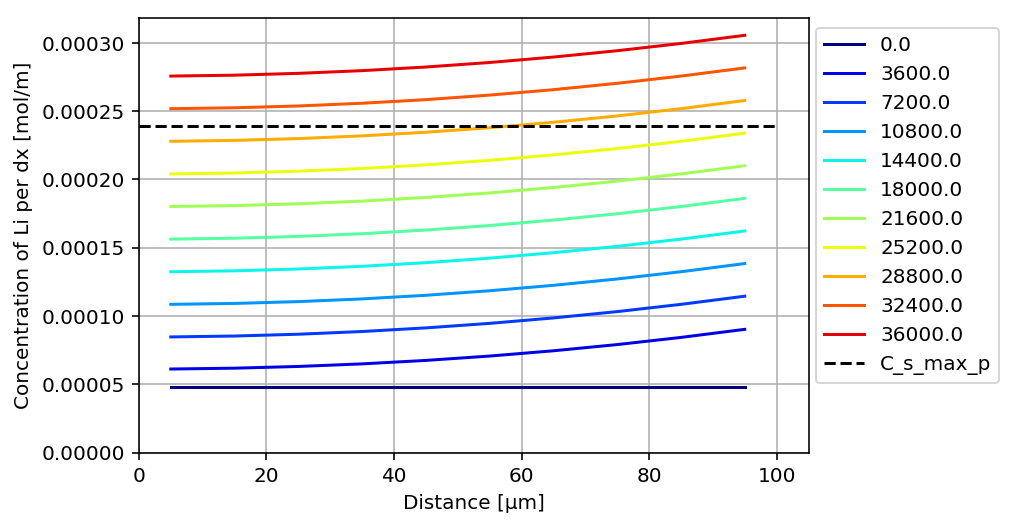

In [454]:
tt=60*60#[sec] delta time for plot
for ii in range(len(time_rlt[time_rlt % tt == 0])):
    plt.plot(x_rlt[time_rlt % tt == 0][ii]*1E6,C_rlt[time_rlt % tt == 0][ii], label = time_rlt[time_rlt % tt == 0][ii],color=cm.jet(ii/len(time_rlt[time_rlt % tt == 0])))
plt.plot(([0,100]),([C_s_max_p*S,C_s_max_p*S]),'--',label='C_s_max_p',color='black')
plt.legend(loc='upper right',
           bbox_to_anchor=(0.9, 0.9, 0.4, .100))
plt.ylabel('Concentration of Li per dx [mol/m]')
plt.xlabel('Distance [μm]')
plt.gca().set_xlim(left=0)
plt.gca().set_ylim(bottom=0)#.xlim(0,100)
plt.grid()
plt.show()

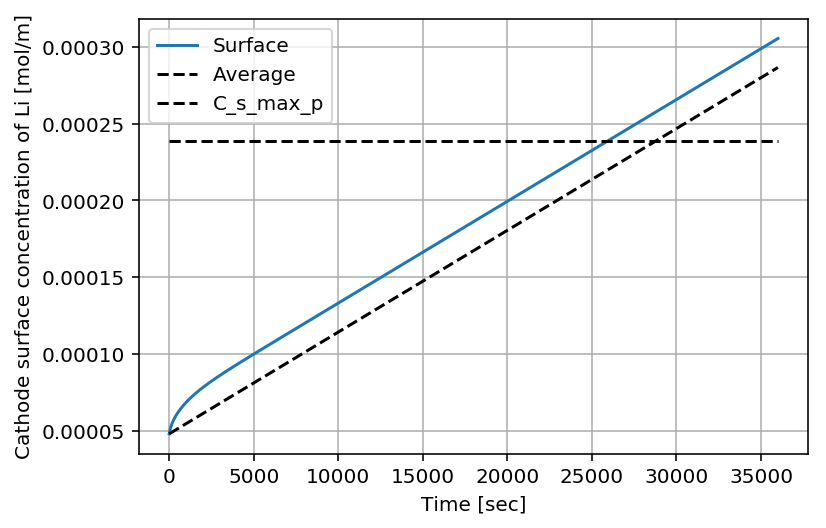

In [456]:
plt.plot(time_rlt,C_rlt[:,-1], label='Surface')
plt.plot(([0,t_total]), ([sum(C_rlt[0,:])/n, sum(C_rlt[-1,:])/n]), '--', color = 'black', label='Average')
plt.plot(([0,36000]),([C_s_max_p*S,C_s_max_p*S]),'--',label='C_s_max_p',color='black')
plt.ylabel('Cathode surface concentration of Li [mol/m]')
plt.xlabel('Time [sec]')
plt.legend()
plt.grid()
plt.show()

In [461]:
# Convert concentration to x stoichiometric ratio of cathode.
slr_p = LinearRegression()
#X_p = np.array([sum(C_rlt[0,:])/n/S, sum(C_rlt[-1,:])/n/S])
#y_p = np.array([min(df_cell['Cathode x (-)']), max(df_cell['Cathode x (-)'])])
X_p = np.array([sum(C_rlt[0,:])/n/S, 0])
y_p = np.array([min(df_cell['Cathode x (-)']), 0])
X_p = X_p.reshape(-1, 1)
y_p = y_p.reshape(-1, 1)
slr_p.fit(X_p, y_p)
slr_p.predict(np.array([0.00025/S]).reshape(-1, 1))

array([[ 1.0460251]])

In [460]:
C_rlt[0,:]

array([  4.78764800e-05,   4.78764800e-05,   4.78764800e-05,
         4.78764800e-05,   4.78764800e-05,   4.78764800e-05,
         4.78764800e-05,   4.78764800e-05,   4.78764800e-05,
         4.78764800e-05])

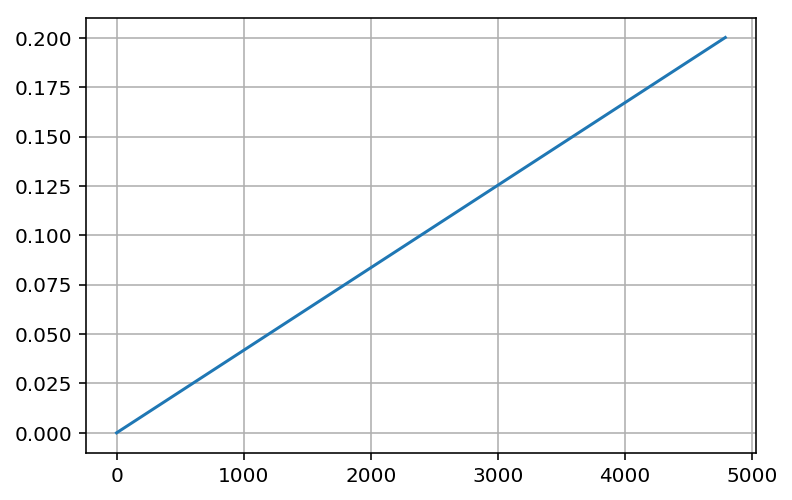

In [462]:
plt.plot(X_p, y_p)
plt.grid()

In [463]:
t1 = time.time()
# Number of partitions of rod (finite elements)
n = 16
dx = N_length/n

t_total = 60*60*10 #[sec] run time
dt = 0.5 #[sec] Time partitions
t_total +=dt
# Make an array with positions of middle of each partition
x = np.linspace(dx/2, N_length - dx/2,n)

# Initialize rod to initial temperature distribution.
C = np.ones(len(x))*C_s_n_0*S
dCdt = np.empty(n)

t = np.arange(0,t_total,dt)

time_rlt_n = np.zeros(len(t)+1)
x_rlt_n = np.zeros((len(t)+1,len(x)))
C_rlt_n = np.zeros((len(t)+1,len(C)))

x_rlt_n[0] = x
C_rlt_n[0] = C

for jj in range(1,len(t)+1):
    for i in range(1,n-1):

        # Applying discrete definition of second derivative
        dCdt[i] = D_n*((C[i+1] - C[i])/dx - (C[i] - C[i-1])/dx)/dx
        
    # Taking into account boundary condition. ie. T[0-1] DNE
    dCdt[0] = D_n*((C[1] - C[0])/dx)/dx
    dCdt[n-1] = D_n*(-j*S/F/D_n - (C[n-1] - C[n-2])/dx)/dx
    
    # Update temperature data for rod
    C = C + dCdt * dt

    time_rlt_n[jj] = (jj)*dt
    x_rlt_n[jj] = x #
    C_rlt_n[jj] = C #concentration per dx
    if jj % divmod(len(t), 10)[0] == 0:
        print('{}'.format(jj/(len(t)-1)*100),'% processed ')

t2 = time.time()
print('{:.2}'.format(t2-t1),'sec')

10.0 % processed 
20.0 % processed 
30.0 % processed 
40.0 % processed 
50.0 % processed 
60.0 % processed 
70.0 % processed 
80.0 % processed 
90.0 % processed 
100.0 % processed 
1.4 sec


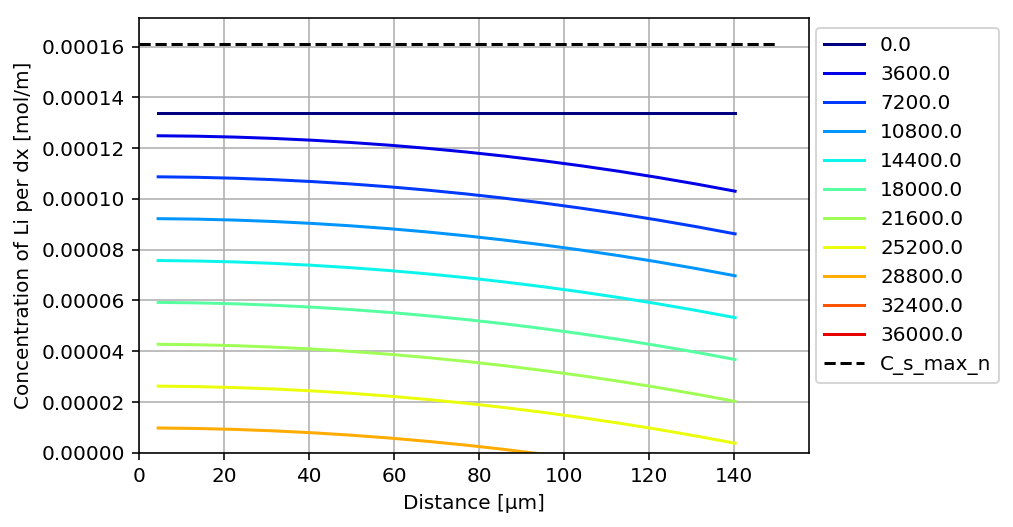

In [464]:
tt=60*60#[sec] delta time for plot
for ii in range(len(time_rlt_n[time_rlt_n % tt == 0])):
    plt.plot(x_rlt_n[time_rlt_n % tt == 0][ii]*1E6,C_rlt_n[time_rlt_n % tt == 0][ii], label = time_rlt_n[time_rlt_n % tt == 0][ii],color=cm.jet(ii/len(time_rlt_n[time_rlt_n % tt == 0])))
plt.plot(([0,150]),([C_s_max_n*S,C_s_max_n*S]),'--',label='C_s_max_n',color='black')
plt.legend(loc='upper right',
           bbox_to_anchor=(0.9, 0.9, 0.4, .100))
plt.ylabel('Concentration of Li per dx [mol/m]')
plt.xlabel('Distance [μm]')
plt.gca().set_ylim(bottom=0)
plt.gca().set_xlim(left=0)
plt.grid()
plt.show()

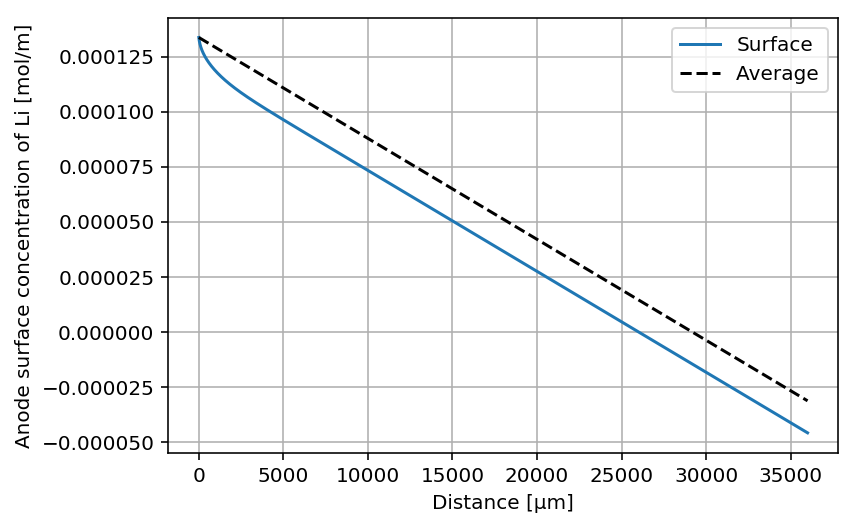

In [465]:
plt.plot(time_rlt_n,C_rlt_n[:,-1], label='Surface')
plt.plot(([0,t_total]), ([sum(C_rlt_n[0,:])/n, sum(C_rlt_n[-1,:])/n]), '--', color = 'black', label='Average')
plt.ylabel('Anode surface concentration of Li [mol/m]')
plt.xlabel('Distance [μm]')
plt.legend()
plt.grid()
plt.show()

In [512]:
# Convert concentration to x stoichiometric ratio of anode.
slr_n = LinearRegression()
#X_n = np.array([sum(C_rlt_n[0,:])/n/S, sum(C_rlt_n[-1,:])/n/S])
#y_n = np.array([min(df_cell['Anode x (-)']), max(df_cell['Anode x (-)'])])
X_n = np.array([sum(C_rlt_n[0,:])/n/S, 0])
y_n = np.array([min(df_cell['Anode x (-)']), 1])
X_n = X_n.reshape(-1, 1)
y_n = y_n.reshape(-1, 1)
slr_n.fit(X_n, y_n)
slr_n.predict(np.array([0.000025/S]).reshape(-1, 1))

array([[ 0.8447205]])

In [511]:
df_cell

,DOD,Cathode x (-),Cathode OCV (V),Anode x (-),Anode OCV (V),Cell OCV (V)
0,0.0,0.20032,4.550720,0.169631,0.034329,4.516391
1,0.1,0.20040,4.550720,0.170686,0.036918,4.513802
2,0.2,0.20132,4.550720,0.171753,0.039765,4.510955
3,0.3,0.20241,4.550720,0.172365,0.039610,4.511110
4,0.4,0.20341,4.549880,0.173068,0.042250,4.507630
...,...,...,...,...,...,...
996,99.6,0.94686,3.923630,0.936868,0.515807,3.407823
997,99.7,0.94786,3.924890,0.937583,0.515807,3.409083
998,99.8,0.94887,3.924050,0.938267,0.518913,3.405137
999,99.9,0.94887,3.924890,0.938267,0.518913,3.405977


In [468]:
df_LiC6_OCV

,x,Potential(V),DOD
10,0.166425,0.025321,-0.464298
11,0.167118,0.026563,-0.374264
12,0.167362,0.027185,-0.342547
13,0.167486,0.027806,-0.326471
14,0.167490,0.027961,-0.326035
...,...,...,...
2277,0.938254,0.523883,99.773204
2278,0.938257,0.522640,99.773639
2279,0.938260,0.521398,99.774075
2280,0.938264,0.520155,99.774510


In [560]:
df_sim = pd.DataFrame(time_rlt)
df_sim.columns = ['Time (sec)']
df_sim['C_s_p_surface (mol/m3)'] = C_rlt[:,-1]/S # Li concentration at the surface of positive electrode material
df_sim['C_s_n_surface (mol/m3)'] = C_rlt_n[:,-1]/S # Li concentration at the surface of positive electrode material

df_sim['Cathode x of surface (-)'] = slr_p.predict(np.array(df_sim['C_s_p_surface (mol/m3)']).reshape(-1, 1))
df_sim['Anode x of surface (-)'] = slr_n.predict(np.array(df_sim['C_s_n_surface (mol/m3)']).reshape(-1, 1))
df_sim['Current density (A/m2)'] = j
df_sim['Capacity (Ah)'] = df_sim['Time (sec)'] * df_sim['Current density (A/m2)']*S/(60*60)

df_sim['DOD'] = df_sim['Capacity (Ah)']/Full_cap*100
df_sim = pd.merge_asof(df_sim, df_LCO_OCV, on='DOD', direction='nearest')
df_sim = pd.merge_asof(df_sim, df_LiC6_OCV, on='DOD', direction='nearest')
df_sim.columns = ['Time (sec)', 'C_s_p_surface (mol/m3)', 'C_s_n_surface (mol/m3)','Cathode x of surface (-)','Anode x of surface (-)', 'Current density (A/m2)', 'Capacity (Ah)', 'DOD (%)', 'Cathode x (-)', 'Cathode OCV (V)', 'Anode x (-)', 'Anode OCV (V)']
df_sim['Cell OCV (V)'] = (df_sim['Cathode OCV (V)']  - df_sim['Anode OCV (V)'])

df_tmp = df_LCO_OCV[['x', 'Potential(V)']]
df_tmp.columns = ['Cathode x of surface (-)','Cathode surface OCV (V)']
df_sim = pd.merge_asof(df_sim, df_tmp, on='Cathode x of surface (-)', direction='nearest')
df_tmp = df_LiC6_OCV[['x', 'Potential(V)']]
df_tmp.columns = ['Anode x of surface (-)','Anode surface OCV (V)']
df_sim = pd.merge_asof(df_sim.sort_values('Anode x of surface (-)') , df_tmp, on='Anode x of surface (-)', direction='nearest')
df_sim = df_sim.sort_values('Time (sec)').reset_index(drop=True)
df_sim = df_sim[df_sim['C_s_p_surface (mol/m3)'] <= C_s_max_p]
df_sim = df_sim[df_sim['Anode x of surface (-)'] <= max(df_LiC6_OCV['x'])]
df_sim


,Time (sec),C_s_p_surface (mol/m3),C_s_n_surface (mol/m3),Cathode x of surface (-),Anode x of surface (-),Current density (A/m2),Capacity (Ah),DOD (%),Cathode x (-),Cathode OCV (V),Anode x (-),Anode OCV (V),Cell OCV (V),Cathode surface OCV (V),Anode surface OCV (V)
0,0.0,4787.648000,13368.948882,0.200320,0.169631,6.4,0.000000e+00,0.000000,0.20032,4.55072,0.169631,0.034329,4.516391,4.55072,0.034329
1,0.5,4790.964566,13365.283181,0.200459,0.169858,6.4,8.888889e-12,0.001851,0.20032,4.55072,0.169631,0.034329,4.516391,4.55072,0.034329
2,1.0,4794.264550,13361.662261,0.200597,0.170083,6.4,1.777778e-11,0.003703,0.20032,4.55072,0.169631,0.034329,4.516391,4.55072,0.034329
3,1.5,4797.548116,13358.085027,0.200734,0.170305,6.4,2.666667e-11,0.005554,0.20032,4.55072,0.169631,0.034329,4.516391,4.55072,0.035572
4,2.0,4800.815429,13354.550420,0.200871,0.170525,6.4,3.555556e-11,0.007405,0.20032,4.55072,0.169631,0.034329,4.516391,4.55072,0.035572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47666,23833.0,22486.835522,994.910068,0.940872,0.938204,6.4,4.236978e-07,88.246782,0.86164,3.92363,0.849830,0.185296,3.738334,3.92363,0.542521
47667,23833.5,22487.167179,994.680962,0.940886,0.938219,6.4,4.237067e-07,88.248633,0.86164,3.92363,0.849830,0.185296,3.738334,3.92363,0.536308
47668,23834.0,22487.498836,994.451855,0.940900,0.938233,6.4,4.237156e-07,88.250485,0.86164,3.92363,0.849830,0.185296,3.738334,3.92363,0.531338
47669,23834.5,22487.830492,994.222749,0.940913,0.938247,6.4,4.237244e-07,88.252336,0.86164,3.92363,0.849830,0.185296,3.738334,3.92363,0.526368


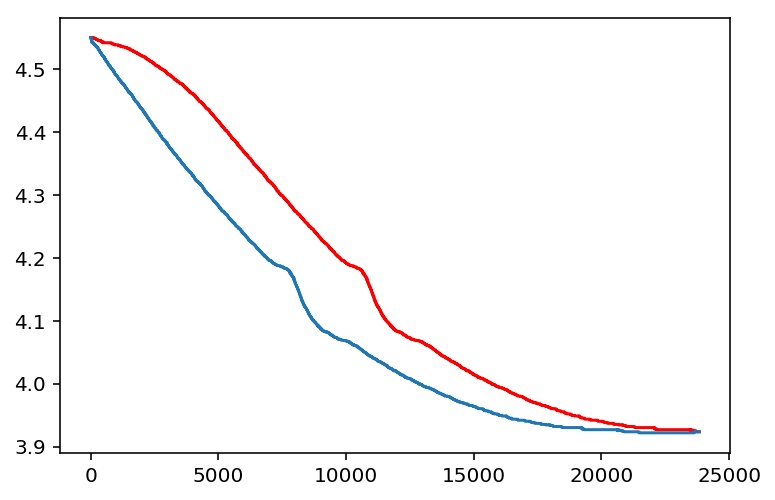

In [563]:
plt.plot(df_sim['Time (sec)'], df_sim['Cathode OCV (V)'], color = 'r')
plt.plot(df_sim['Time (sec)'], df_sim['Cathode surface OCV (V)'])

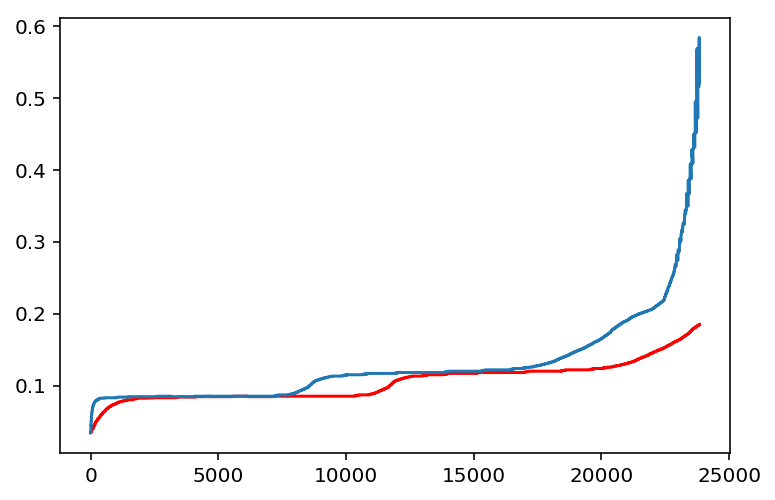

In [564]:
plt.plot(df_sim['Time (sec)'], df_sim['Anode OCV (V)'], color = 'r')
plt.plot(df_sim['Time (sec)'], df_sim['Anode surface OCV (V)'])

## Overpotential by foil electronic resistance
\begin{eqnarray*}
\rho(T) = \rho_0[1+\alpha(T-T_0)]
\end{eqnarray*}

In [565]:
#resistivity at 294.15K (20deg.C)
rho_0_Al = 2.82E-8#[ohm m]
rho_0_Cu = 1.68E-8#[ohm m]
alpha_Al = 0.0039#[/K]
alpha_Cu = 0.003862#[/K]

In [566]:
#Overpotential by foil resistance
DV_Al = rho_0_Al * (1 + alpha_Al*(T - temp_0)) * Al_length / S *I
DV_Cu = rho_0_Cu * (1 + alpha_Cu*(T - temp_0)) * Cu_length / S *I
print(DV_Al)
print(DV_Cu)

1.8178216320000008e-10
1.0828819814400002e-10


In [567]:
df_sim['DV_Al'] = rho_0_Al * (1 + alpha_Al*(T - temp_0)) * Al_length / S *I
df_sim['DV_Cu'] = rho_0_Cu * (1 + alpha_Cu*(T - temp_0)) * Cu_length / S *I

## Overpotential by Butler-volmer equation

\begin{eqnarray*}
j = j_0 \left( \exp \left[\frac{\alpha_a zF\eta}{RT}\right] - \exp \left[-\frac{\alpha_c zF\eta}{RT}\right]\right)\\
j_0 = zFk^o(C_e)^{\alpha_a}(C_{s,max}-C_s)^{\alpha_a}(C_s)^{\alpha_c}
\end{eqnarray*}

\begin{eqnarray*}
\eta = \frac{RT}{\alpha zF}ln\left(\frac{j}{2j_0} + \sqrt{\left(\frac{j}{2j_0}\right)^2 + 1} \right)
\end{eqnarray*}

In [568]:
df_sim['j_0_p (A/m2)'] = z*F*k_o_p*C_e**alpha*(C_s_max_p - df_sim['C_s_p_surface (mol/m3)'])**alpha*(df_sim['C_s_p_surface (mol/m3)'])**alpha#[A/m2]
df_sim['j_0_n (A/m2)'] = z*F*k_o_n*C_e**alpha*(C_s_max_n - df_sim['C_s_n_surface (mol/m3)'])**alpha*(df_sim['C_s_n_surface (mol/m3)'])**alpha#[A/m2]
df_sim['DV_eta_p'] = (R*T)/(alpha*z*F)*np.log(df_sim['Current density (A/m2)']/(2*df_sim['j_0_p (A/m2)']) + ((df_sim['Current density (A/m2)']/(2*df_sim['j_0_p (A/m2)']))**2 + 1)**0.5)
df_sim['DV_eta_n'] = (R*T)/(alpha*z*F)*np.log(df_sim['Current density (A/m2)']/(2*df_sim['j_0_n (A/m2)']) + ((df_sim['Current density (A/m2)']/(2*df_sim['j_0_n (A/m2)']))**2 + 1)**0.5)
df_sim['Cathode CCV (V)'] = df_sim['Cathode surface OCV (V)']  - df_sim['DV_Al'] - df_sim['DV_eta_p']
df_sim['Anode CCV (V)'] = df_sim['Anode surface OCV (V)']  + df_sim['DV_Cu'] + df_sim['DV_eta_n']
df_sim['Cell CCV (V)'] = df_sim['Cathode CCV (V)'] - df_sim['Anode CCV (V)']
df_sim = df_sim.dropna()
df_sim

,Time (sec),C_s_p_surface (mol/m3),C_s_n_surface (mol/m3),Cathode x of surface (-),Anode x of surface (-),Current density (A/m2),Capacity (Ah),DOD (%),Cathode x (-),Cathode OCV (V),...,Anode surface OCV (V),DV_Al,DV_Cu,j_0_p (A/m2),j_0_n (A/m2),DV_eta_p,DV_eta_n,Cathode CCV (V),Anode CCV (V),Cell CCV (V)
0,0.0,4787.648000,13368.948882,0.200320,0.169631,6.4,0.000000e+00,0.000000,0.20032,4.55072,...,0.034329,1.817822e-10,1.082882e-10,0.684128,0.927477,0.115412,0.100251,4.435308,0.134580,4.300728
1,0.5,4790.964566,13365.283181,0.200459,0.169858,6.4,8.888889e-12,0.001851,0.20032,4.55072,...,0.034329,1.817822e-10,1.082882e-10,0.684305,0.927972,0.115399,0.100225,4.435321,0.134554,4.300768
2,1.0,4794.264550,13361.662261,0.200597,0.170083,6.4,1.777778e-11,0.003703,0.20032,4.55072,...,0.034329,1.817822e-10,1.082882e-10,0.684482,0.928461,0.115386,0.100199,4.435334,0.134528,4.300807
3,1.5,4797.548116,13358.085027,0.200734,0.170305,6.4,2.666667e-11,0.005554,0.20032,4.55072,...,0.035572,1.817822e-10,1.082882e-10,0.684657,0.928942,0.115373,0.100173,4.435347,0.135745,4.299602
4,2.0,4800.815429,13354.550420,0.200871,0.170525,6.4,3.555556e-11,0.007405,0.20032,4.55072,...,0.035572,1.817822e-10,1.082882e-10,0.684832,0.929418,0.115360,0.100148,4.435360,0.135719,4.299641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47666,23833.0,22486.835522,994.910068,0.940872,0.938204,6.4,4.236978e-07,88.246782,0.86164,3.92363,...,0.542521,1.817822e-10,1.082882e-10,0.403162,0.595036,0.142196,0.122439,3.781434,0.664960,3.116474
47667,23833.5,22487.167179,994.680962,0.940886,0.938219,6.4,4.237067e-07,88.248633,0.86164,3.92363,...,0.536308,1.817822e-10,1.082882e-10,0.403118,0.594972,0.142202,0.122444,3.781428,0.658752,3.122676
47668,23834.0,22487.498836,994.451855,0.940900,0.938233,6.4,4.237156e-07,88.250485,0.86164,3.92363,...,0.531338,1.817822e-10,1.082882e-10,0.403073,0.594908,0.142208,0.122450,3.781422,0.653788,3.127635
47669,23834.5,22487.830492,994.222749,0.940913,0.938247,6.4,4.237244e-07,88.252336,0.86164,3.92363,...,0.526368,1.817822e-10,1.082882e-10,0.403029,0.594844,0.142213,0.122455,3.781417,0.648823,3.132594


df_sim['j_0_p (A/m2)'] = z*F*k_o_p*C_e**alpha*(C_s_max_p - df_sim['C_s_p_surface (mol/m3)'])**alpha*(df_sim['C_s_p_surface (mol/m3)'])**alpha#[A/m2]
df_sim['j_0_n (A/m2)'] = z*F*k_o_n*C_e**alpha*(C_s_max_n - df_sim['Anode x (-)']*C_s_max_n)**alpha*(df_sim['Anode x (-)']*C_s_max_n)**alpha#[A/m2]
df_sim['DV_eta_p'] = (R*T)/(alpha*z*F)*np.log(df_sim['Current density (A/m2)']/(2*df_sim['j_0_p (A/m2)']) + ((df_sim['Current density (A/m2)']/(2*df_sim['j_0_p (A/m2)']))**2 + 1)**0.5)
df_sim['DV_eta_n'] = (R*T)/(alpha*z*F)*np.log(df_sim['Current density (A/m2)']/(2*df_sim['j_0_n (A/m2)']) + ((df_sim['Current density (A/m2)']/(2*df_sim['j_0_n (A/m2)']))**2 + 1)**0.5)
df_sim['Cathode CCV (V)'] = df_sim['Cathode OCV (V)']  - df_sim['DV_Al'] - df_sim['DV_eta_p']
df_sim['Anode CCV (V)'] = df_sim['Anode OCV (V)']  + df_sim['DV_Cu'] + df_sim['DV_eta_n']
df_sim['Cell CCV (V)'] = df_sim['Cathode CCV (V)'] - df_sim['Anode CCV (V)']
df_sim = df_sim.dropna()
df_sim

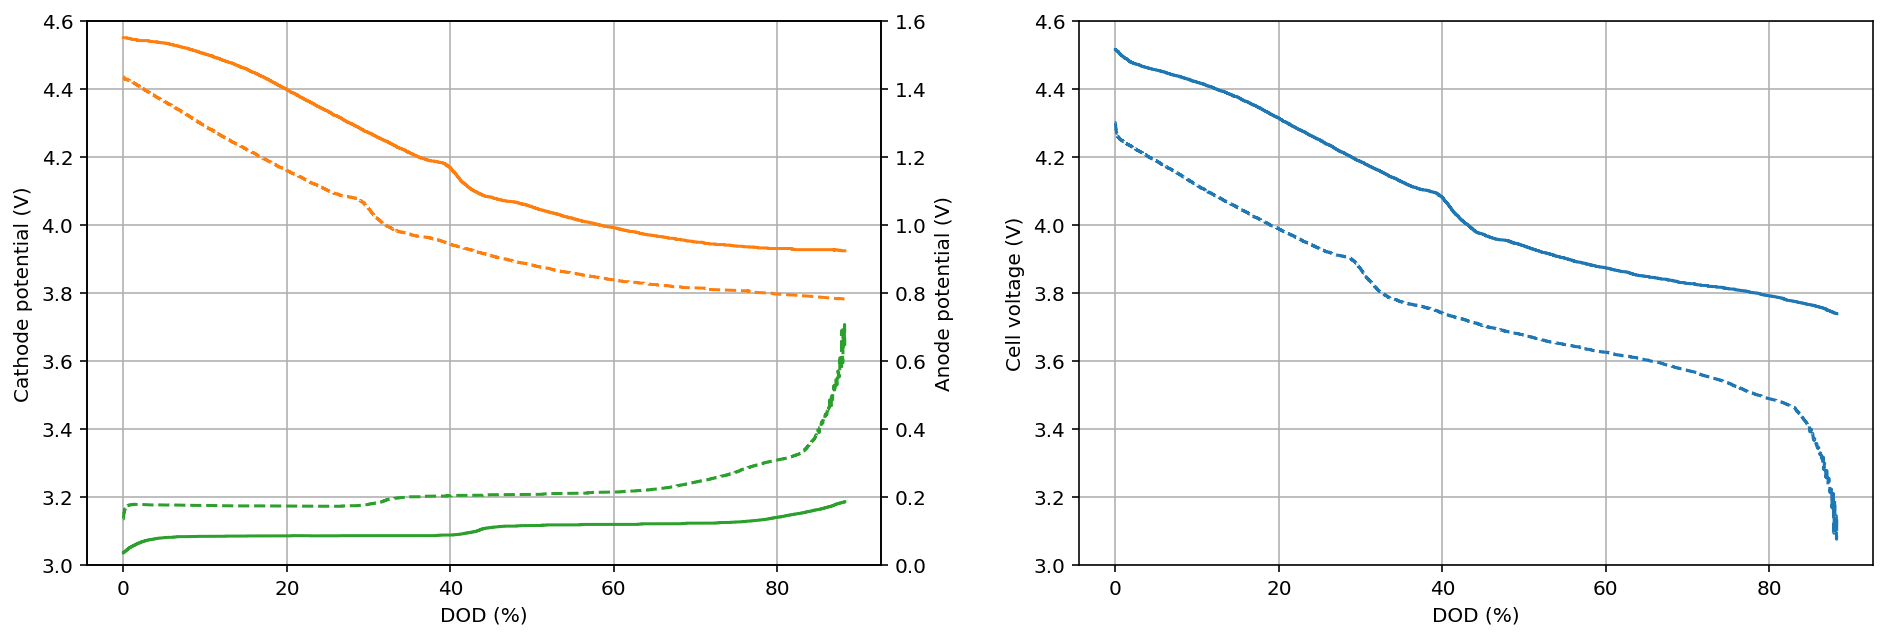

In [569]:
fig, (ax1,ax3) = plt.subplots(1,2,figsize=(16, 5))
plt.subplots_adjust(wspace=0.25)
ax2 = ax1.twinx()
ax1.plot(df_sim['DOD (%)'], df_sim['Cathode OCV (V)'], color = new_colors[1])
ax1.plot(df_sim['DOD (%)'], df_sim['Cathode CCV (V)'],'--', color = new_colors[1])
ax1.set_ylabel('Cathode potential (V)')
ax2.plot(df_sim['DOD (%)'], df_sim['Anode OCV (V)'], color = new_colors[2])
ax2.plot(df_sim['DOD (%)'], df_sim['Anode CCV (V)'],'--', color = new_colors[2])
ax2.set_ylabel('Anode potential (V)')
ax1.set_xlabel('DOD (%)')

ax1.set_ylim([3, 4.6])
ax2.set_ylim([0, 1.6])

ax1.grid()



ax3.plot(df_sim['DOD (%)'], df_sim['Cell OCV (V)'], color = new_colors[0])
ax3.plot(df_sim['DOD (%)'], df_sim['Cell CCV (V)'],'--', color = new_colors[0])
ax3.set_ylabel('Cell voltage (V)')
ax3.set_xlabel('DOD (%)')
ax3.set_ylim([3, 4.6])

ax3.grid()

plt.show()




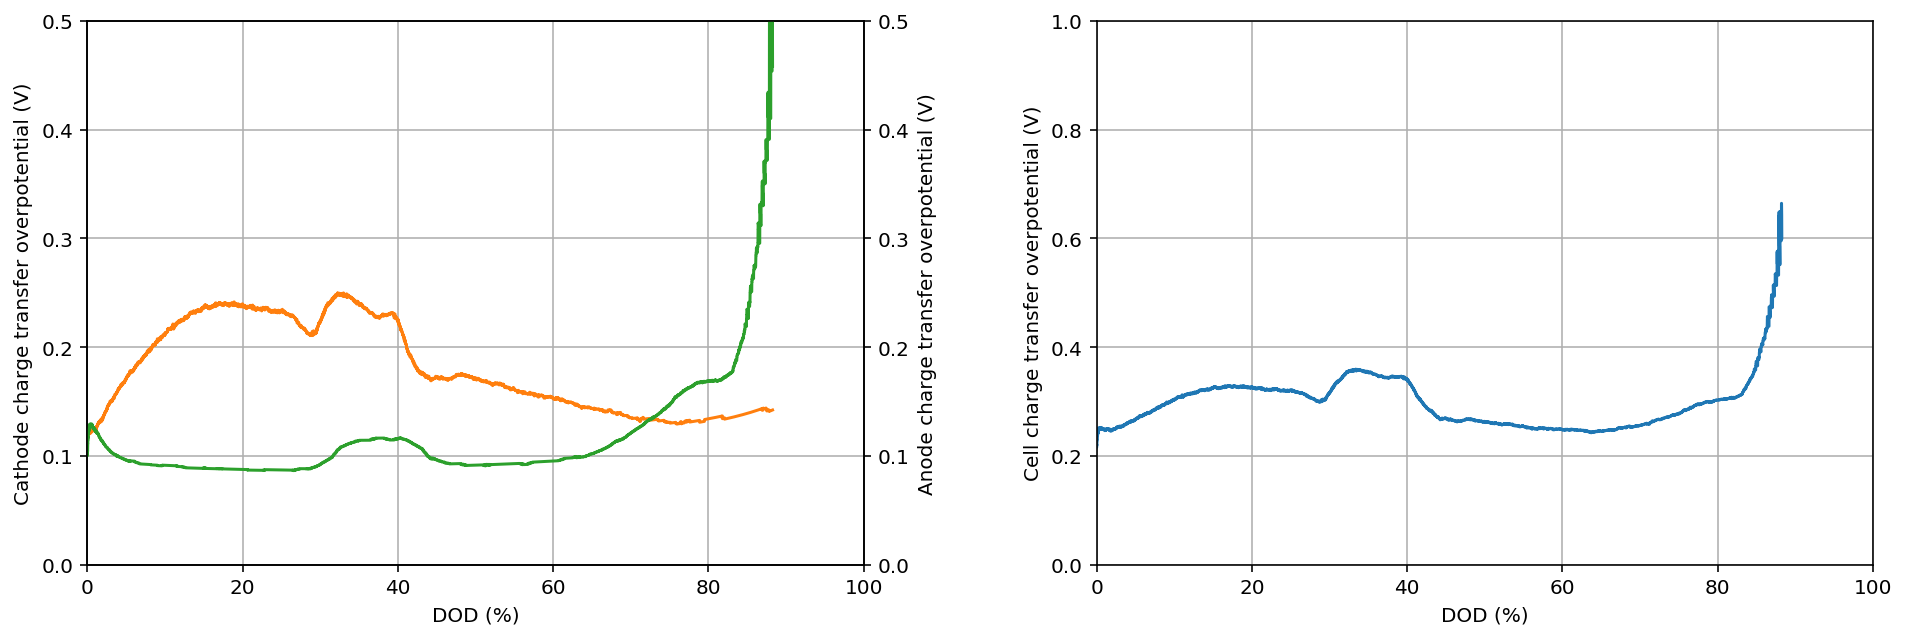

In [574]:
fig, (ax1,ax3) = plt.subplots(1,2,figsize=(16, 5))
plt.subplots_adjust(wspace=0.3)
ax2 = ax1.twinx()
ax1.plot(df_sim['DOD (%)'], (df_sim['Cathode OCV (V)'] - df_sim['Cathode CCV (V)']), color = new_colors[1])
ax1.set_ylabel('Cathode charge transfer overpotential (V)')
ax2.plot(df_sim['DOD (%)'], (df_sim['Anode CCV (V)'] - df_sim['Anode OCV (V)']), color = new_colors[2])
ax2.set_ylabel('Anode charge transfer overpotential (V)')
ax1.set_xlabel('DOD (%)')

ax1.set_ylim([0, 0.5])
ax2.set_ylim([0, 0.5])
ax1.set_xlim([0, 100])

ax1.grid()


ax3.plot(df_sim['DOD (%)'], (df_sim['Cell OCV (V)'] - df_sim['Cell CCV (V)']), color = new_colors[0])
ax3.set_ylabel('Cell charge transfer overpotential (V)')
ax3.set_xlabel('DOD (%)')
ax3.set_ylim([0, 1.0])
ax3.set_xlim([0, 100])
ax3.grid()

plt.show()

## Appendix

In [196]:
#LCO lattice parameter
a_hex = 2.8138E-10#[m]
c_hex = 14.0516E-10#[m]
# 3LiCoO2
N_A = 6.0221367E23#Avogadro constant
C_s_max_p = 1/(N_A/3*a_hex*a_hex*c_hex)#[mol/m3]

In [1]:
x = ((np.arange(10100)))/10E3
t=10
C_p =C_s_max_p*10E-6 - (I/(z*F*S*10E4*D_p*10E4)*(2*((D_p*10E4*t/np.pi)**0.5 * np.exp(-x**2/(4*D_p*10E4*t)-x*special.erfc(x/(2*(D_p*10E4*t)**0.5))))))
plt.plot(x,C_p)
t=60
C_p =C_s_max_p*10E-6 - (I/(z*F*S*10E4*D_p*10E4)*(2*((D_p*10E4*t/np.pi)**0.5 * np.exp(-x**2/(4*D_p*10E4*t)-x*special.erfc(x/(2*(D_p*10E4*t)**0.5))))))
plt.plot(x,C_p)
t=8000
C_p =C_s_max_p*10E-6 - (I/(z*F*S*10E4*D_p*10E4)*(2*((D_p*10E4*t/np.pi)**0.5 * np.exp(-x**2/(4*D_p*10E4*t)-x*special.erfc(x/(2*(D_p*10E4*t)**0.5))))))
plt.plot(x,C_p)

NameError: name 'np' is not defined

In [151]:
#Temperature
T = 298#[K]
temp_0 = 23 + 273.15#[K]

#Dimension
L1 = 100E-6#[m]
L2 = 200E-6#[m]
L3 = 300E-6#[m]
L4 = 400E-6#[m]
L5 = 500E-6#[m]
M = 100E-6#[m]
N = 100E-6#[m]
S = M * N#[m2]

Al_length = L1
Cu_length = L5 - L4
P_length = L2-L1
N_length = L4-L3

#Current
I = 5E-7#[A]
j = I/S
#Constant
R = 8.3144598#[J/(mol K)]
F = 96485.33289#[C/mol]
z = 1
alpha=0.5
k_o_p = 7.13E-8
k_o_n = 1.47E-7
C_e = 1000#[mol/m3]
#C_s_max_p = 2.39E4#[mol/m3]
C_s_max_n = 1.61E4#[mol/m3]

#Diffusion coefficient
D_p = 1.0E-14#[m2/s]
D_n = 3.9E-16#[m2/s]




In [ ]:
C_0=1
i=1
n=1

In [36]:
x = ((np.arange(101)))/100
t=0.1
C= 1 - (2*(t/np.pi)**0.5*np.exp(-x**2/t) - x*special.erfc(x/t**0.5))

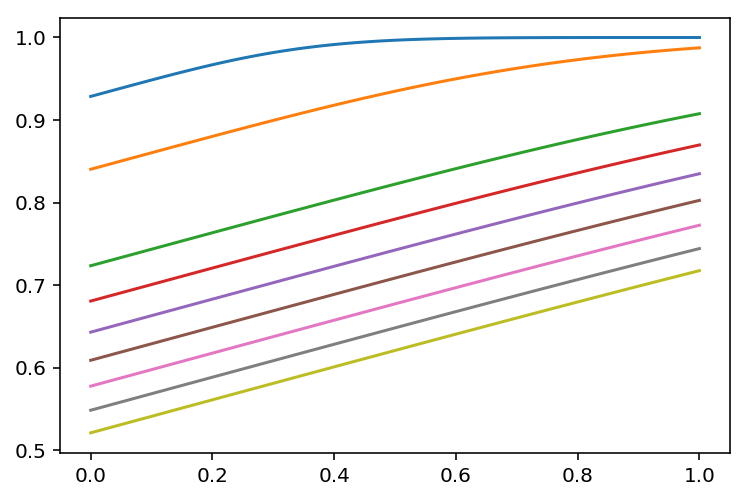

In [49]:
t=0.1
plt.plot(x,1 - 0.2*(2*(t/np.pi)**0.5*np.exp(-x**2/t) - x*special.erfc(x/t**0.5)))
t=0.5
plt.plot(x,1 - 0.2*(2*(t/np.pi)**0.5*np.exp(-x**2/t) - x*special.erfc(x/t**0.5)))
t=1.5
plt.plot(x,1 - 0.2*(2*(t/np.pi)**0.5*np.exp(-x**2/t) - x*special.erfc(x/t**0.5)))
t=2
plt.plot(x,1 - 0.2*(2*(t/np.pi)**0.5*np.exp(-x**2/t) - x*special.erfc(x/t**0.5)))
t=2.5
plt.plot(x,1 - 0.2*(2*(t/np.pi)**0.5*np.exp(-x**2/t) - x*special.erfc(x/t**0.5)))
t=3
plt.plot(x,1 - 0.2*(2*(t/np.pi)**0.5*np.exp(-x**2/t) - x*special.erfc(x/t**0.5)))
t=3.5
plt.plot(x,1 - 0.2*(2*(t/np.pi)**0.5*np.exp(-x**2/t) - x*special.erfc(x/t**0.5)))
t=4
plt.plot(x,1 - 0.2*(2*(t/np.pi)**0.5*np.exp(-x**2/t) - x*special.erfc(x/t**0.5)))
t=4.5
plt.plot(x,1 - 0.2*(2*(t/np.pi)**0.5*np.exp(-x**2/t) - x*special.erfc(x/t**0.5)))





In [26]:
#Temperature
T = 298#[K]
temp_0 = 23 + 273.15#[K]

In [27]:
#Dimension
L1 = 100E-6#[m]
L2 = 200E-6#[m]
L3 = 300E-6#[m]
L4 = 400E-6#[m]
L5 = 500E-6#[m]
M = 100E-6#[m]
N = 100E-6#[m]
S = M * N#[m2]

In [28]:
#Current
I = 5E-7#[A]
print(I/S)#[A/m2]

50.0


In [29]:
Al_length = L1
Cu_length = L5 - L4

In [30]:
#Overpotential by foil resistance
DV_Al = rho_0_Al * (1 + alpha_Al*(T - temp_0)) * Al_length / S *I
DV_Cu = rho_0_Cu * (1 + alpha_Cu*(T - temp_0)) * Cu_length / S *I
print(DV_Al)
print(DV_Cu)

1.4201731500000005e-10
8.46001548e-11


## Overpotential by Butler-volmer equation

\begin{eqnarray*}
j = j_0 \left( \exp \left[\frac{\alpha_a zF\eta}{RT}\right] - \exp \left[-\frac{\alpha_c zF\eta}{RT}\right]\right)\\
j_0 = zFk^o(C_e)^{\alpha_a}(C_{s,max}-C_s)^{\alpha_a}(C_s)^{\alpha_c}
\end{eqnarray*}

In [34]:
R = 8.3144598#[J/(mol K)]
F = 96485.33289#[C/mol]
z = 1
alpha=0.5
k_o_p = 7.13E-8
k_o_n = 1.47E-7
T = 298#[K]

C_e = 1000#[mol/m3]
C_s_max_p = 2.39E2#[mol/m3]
C_s_max_n = 1.61E2#[mol/m3]

In [37]:
j_0_p = z*F*k_o_p*C_e**alpha*(C_s_max_p - 0.5*C_s_max_p)**alpha*(0.5*C_s_max_p)**alpha#[A/m2]
j_0_n = z*F*k_o_n*C_e**alpha*(C_s_max_n - 0.5*C_s_max_n)**alpha*(0.5*C_s_max_n)**alpha#[A/m2]

In [38]:
eta = ((np.arange(101))-50)/400

In [39]:
j_p = j_0_p*(np.exp((alpha * z * F * eta) / (R*T)) - np.exp(-1*((1 - alpha) * z * F * eta) / (R*T)))
j_n = j_0_n*(np.exp((alpha * z * F * eta) / (R*T)) - np.exp(-1*((1 - alpha) * z * F * eta) / (R*T)))

In [40]:
j_p_c = j_0_p*(- np.exp(-1*((1 - alpha) * z * F * eta) / (R*T)))
j_p_a = j_0_p*(np.exp((alpha * z * F * eta) / (R*T)))

In [41]:
j_n_c = j_0_n*(- np.exp(-1*((1 - alpha) * z * F * eta) / (R*T)))
j_n_a = j_0_n*(np.exp((alpha * z * F * eta) / (R*T)))

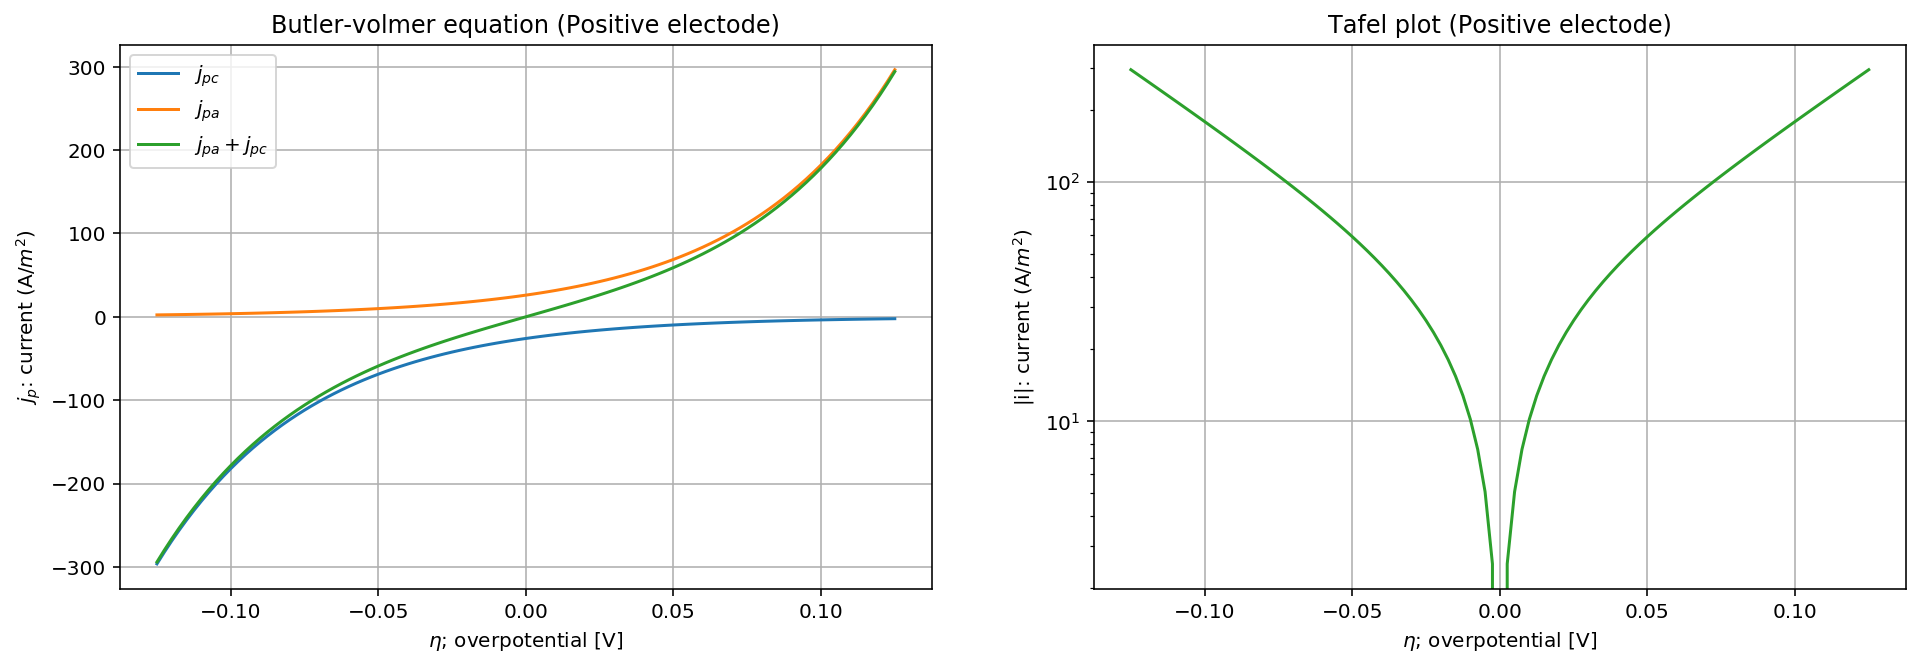

In [42]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16, 5))

ax1.plot(eta, (j_p_c), label = '$j_{pc}$', color=new_colors[0])
ax1.plot(eta, (j_p_a), label = '$j_{pa}$', color=new_colors[1])
ax1.plot(eta, (j_p_c + j_p_a), label = '$j_{pa} + j_{pc}$', color=new_colors[2])


#ax1.set_yscale('log')
ax1.grid()

ax1.set_ylabel('$j_p$: current (A/$m^2$)')
ax1.set_xlabel('$\eta$; overpotential [V]')
ax1.legend()
ax1.set_title('Butler-volmer equation (Positive electode)')


ax2.plot(eta, abs(j_p_c + j_p_a), color=new_colors[2])
ax2.set_yscale('log')
ax2.grid()

ax2.set_ylabel('|i|: current (A/$m^2$)')
ax2.set_xlabel('$\eta$; overpotential [V]')
ax2.set_title('Tafel plot (Positive electode)')

plt.show()



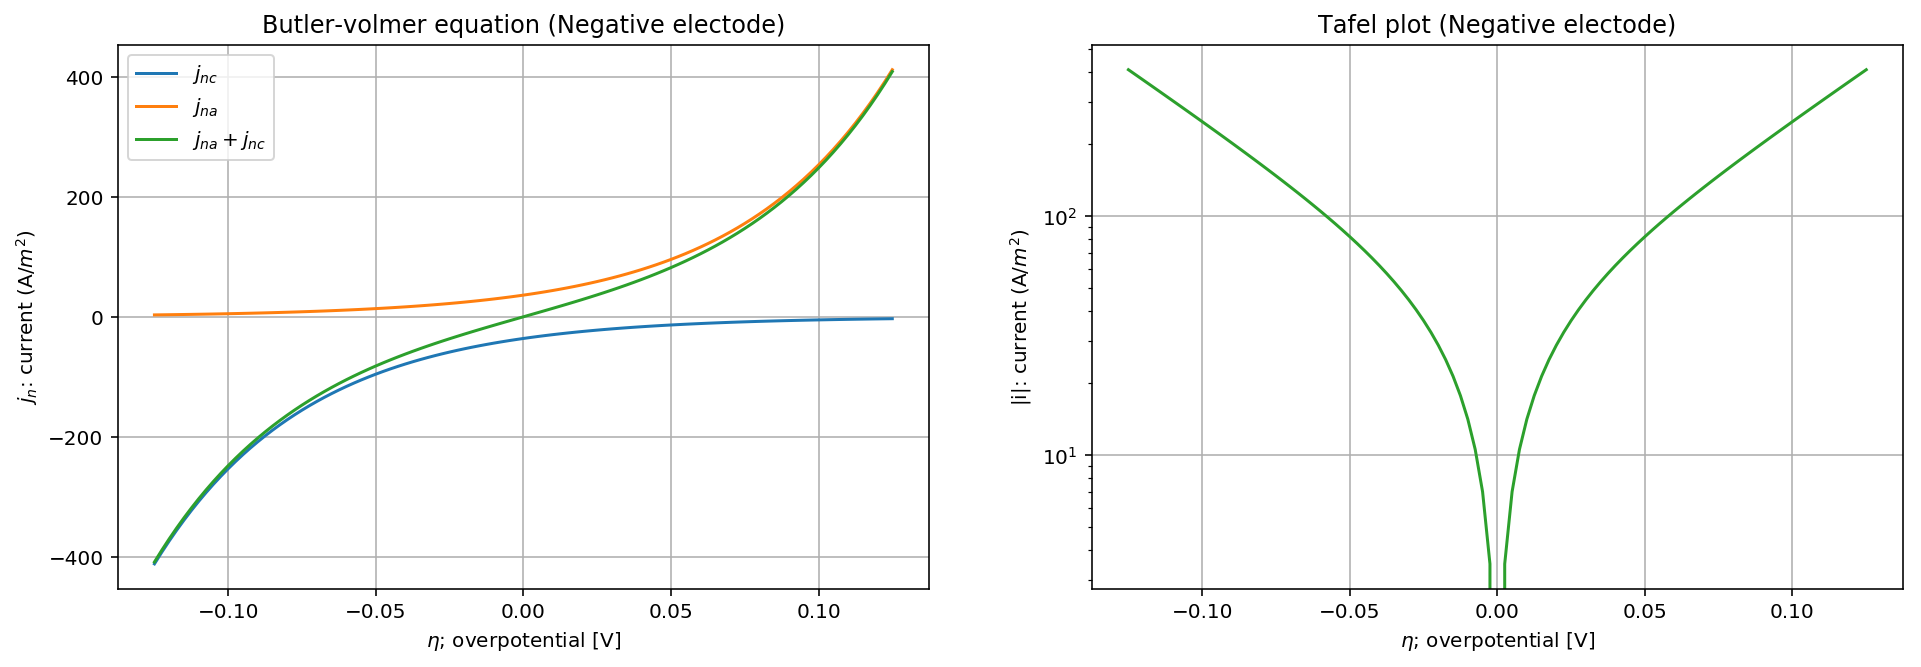

In [43]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16, 5))

ax1.plot(eta, (j_n_c), label = '$j_{nc}$', color=new_colors[0])
ax1.plot(eta, (j_n_a), label = '$j_{na}$', color=new_colors[1])
ax1.plot(eta, (j_n_c + j_n_a), label = '$j_{na} + j_{nc}$', color=new_colors[2])


#ax1.set_yscale('log')
ax1.grid()

ax1.set_ylabel('$j_n$: current (A/$m^2$)')
ax1.set_xlabel('$\eta$; overpotential [V]')
ax1.legend()
ax1.set_title('Butler-volmer equation (Negative electode)')


ax2.plot(eta, abs(j_n_c + j_n_a), color=new_colors[2])
ax2.set_yscale('log')
ax2.grid()

ax2.set_ylabel('|i|: current (A/$m^2$)')
ax2.set_xlabel('$\eta$; overpotential [V]')
ax2.set_title('Tafel plot (Negative electode)')

plt.show()




\begin{eqnarray*}
\eta = \frac{RT}{\alpha zF}ln\left(\frac{j}{2j_0} + \sqrt{\left(\frac{j}{2j_0}\right)^2 + 1} \right)
\end{eqnarray*}

In [44]:
j = ((np.arange(1001))-500)+0.1
j

array([-499.9, -498.9, -497.9, ...,  498.1,  499.1,  500.1])

In [45]:
eta_p = (R*T)/(alpha*z*F)*np.log(j/(2*j_0_p) + ((j/(2*j_0_p))**2 + 1)**0.5)
eta_n = (R*T)/(alpha*z*F)*np.log(j/(2*j_0_n) + ((j/(2*j_0_n))**2 + 1)**0.5)

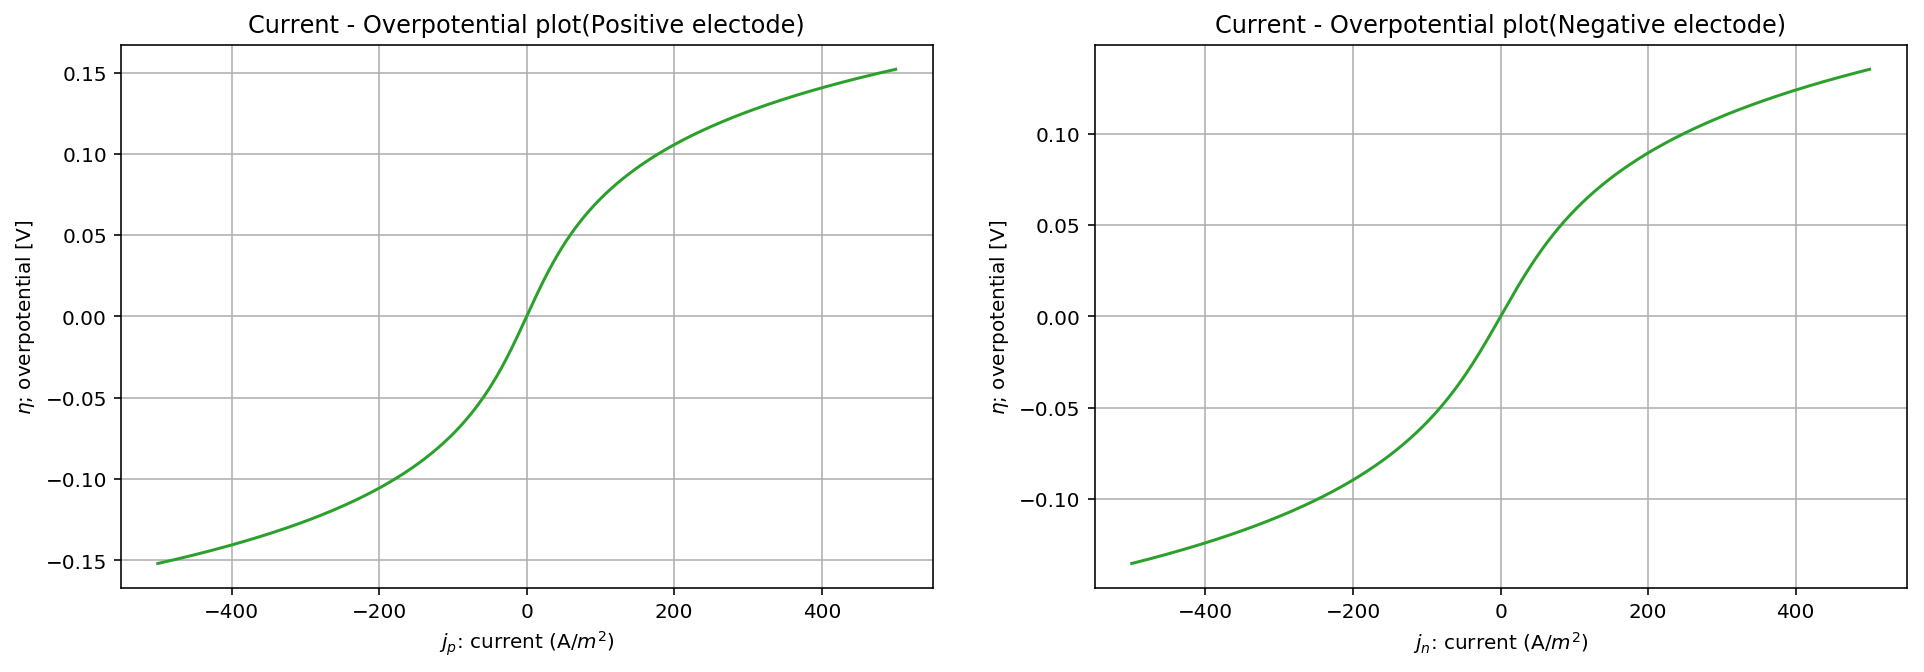

In [46]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16, 5))

ax1.plot(j, eta_p, color=new_colors[2])
ax1.grid()

ax1.set_xlabel('$j_p$: current (A/$m^2$)')
ax1.set_ylabel('$\eta$; overpotential [V]')
ax1.set_title('Current - Overpotential plot(Positive electode)')

ax2.plot(j, eta_n, color=new_colors[2])
ax2.grid()

ax2.set_xlabel('$j_n$: current (A/$m^2$)')
ax2.set_ylabel('$\eta$; overpotential [V]')
ax2.set_title('Current - Overpotential plot(Negative electode)')

plt.show()

## Cell CCV curve simulation

In [47]:
df_cell

,DOD,Cathode x (-),Cathode OCV (V),Anode x (-),Anode OCV (V),Cell OCV (V)
0,0.0,0.20032,4.550720,0.169631,0.034329,4.516391
1,0.1,0.20040,4.550720,0.170686,0.036918,4.513802
2,0.2,0.20132,4.550720,0.171753,0.039765,4.510955
3,0.3,0.20241,4.550720,0.172365,0.039610,4.511110
4,0.4,0.20341,4.549880,0.173068,0.042250,4.507630
...,...,...,...,...,...,...
996,99.6,0.94686,3.923630,0.936868,0.515807,3.407823
997,99.7,0.94786,3.924890,0.937583,0.515807,3.409083
998,99.8,0.94887,3.924050,0.938267,0.518913,3.405137
999,99.9,0.94887,3.924890,0.938267,0.518913,3.405977


In [60]:
#resistivity at 294.15K (20deg.C)
rho_0_Al = 2.82E-8#[ohm m]
rho_0_Cu = 1.68E-8#[ohm m]
alpha_Al = 0.0039#[/K]
alpha_Cu = 0.003862#[/K]

#Temperature
T = 298#[K]
temp_0 = 23 + 273.15#[K]

#Dimension
L1 = 100E-6#[m]
L2 = 200E-6#[m]
L3 = 300E-6#[m]
L4 = 400E-6#[m]
L5 = 500E-6#[m]
M = 100E-6#[m]
N = 100E-6#[m]
S = M * N#[m2]

Al_length = L1
Cu_length = L5 - L4

#Current
I = 5E-7#[A]
j = I/S
#Constant
R = 8.3144598#[J/(mol K)]
F = 96485.33289#[C/mol]
z = 1
alpha=0.5
k_o_p = 7.13E-8
k_o_n = 1.47E-7
C_e = 1000#[mol/m3]
C_s_max_p = 2.39E2#[mol/m3]
C_s_max_n = 1.61E2#[mol/m3]

In [61]:
df_cell['DV_Al'] = rho_0_Al * (1 + alpha_Al*(T - temp_0)) * Al_length / S *I
df_cell['DV_Cu'] = rho_0_Cu * (1 + alpha_Cu*(T - temp_0)) * Cu_length / S *I

In [62]:
x_p = df_cell['Cathode x (-)']
x_n = 1-df_cell['Anode x (-)']
j_0_p = z*F*k_o_p*C_e**alpha*(C_s_max_p - x_p*C_s_max_p)**alpha*(0.5*C_s_max_p)**alpha#[A/m2]
j_0_n = z*F*k_o_n*C_e**alpha*(C_s_max_n - x_n*C_s_max_n)**alpha*(0.5*C_s_max_n)**alpha#[A/m2]

In [63]:
#Overpotential by charge transfer 
df_cell['DV_eta_p'] = (R*T)/(alpha*z*F)*np.log(j/(2*j_0_p) + ((j/(2*j_0_p))**2 + 1)**0.5)

df_cell['DV_eta_n'] = (R*T)/(alpha*z*F)*np.log(j/(2*j_0_n) + ((j/(2*j_0_n))**2 + 1)**0.5)
df_cell

,DOD,Cathode x (-),Cathode OCV (V),Anode x (-),Anode OCV (V),Cell OCV (V),DV_Al,DV_Cu,DV_eta_p,DV_eta_n
0,0.0,0.20032,4.550720,0.169631,0.034329,4.516391,1.420173e-10,8.460015e-11,0.036026,0.051809
1,0.1,0.20040,4.550720,0.170686,0.036918,4.513802,1.420173e-10,8.460015e-11,0.036028,0.051688
2,0.2,0.20132,4.550720,0.171753,0.039765,4.510955,1.420173e-10,8.460015e-11,0.036046,0.051565
3,0.3,0.20241,4.550720,0.172365,0.039610,4.511110,1.420173e-10,8.460015e-11,0.036067,0.051496
4,0.4,0.20341,4.549880,0.173068,0.042250,4.507630,1.420173e-10,8.460015e-11,0.036086,0.051416
...,...,...,...,...,...,...,...,...,...,...
996,99.6,0.94686,3.923630,0.936868,0.515807,3.407823,1.420173e-10,8.460015e-11,0.092573,0.024983
997,99.7,0.94786,3.924890,0.937583,0.515807,3.409083,1.420173e-10,8.460015e-11,0.093035,0.024974
998,99.8,0.94887,3.924050,0.938267,0.518913,3.405137,1.420173e-10,8.460015e-11,0.093512,0.024965
999,99.9,0.94887,3.924890,0.938267,0.518913,3.405977,1.420173e-10,8.460015e-11,0.093512,0.024965


In [65]:
df_cell['Cathode CCV (V)'] = df_cell['Cathode OCV (V)']  - df_cell['DV_Al'] - df_cell['DV_eta_p']
df_cell['Anode CCV (V)'] = df_cell['Anode OCV (V)']  + df_cell['DV_Cu'] + df_cell['DV_eta_n']
df_cell['Cell CCV (V)'] = df_cell['Cathode CCV (V)'] - df_cell['Anode CCV (V)']


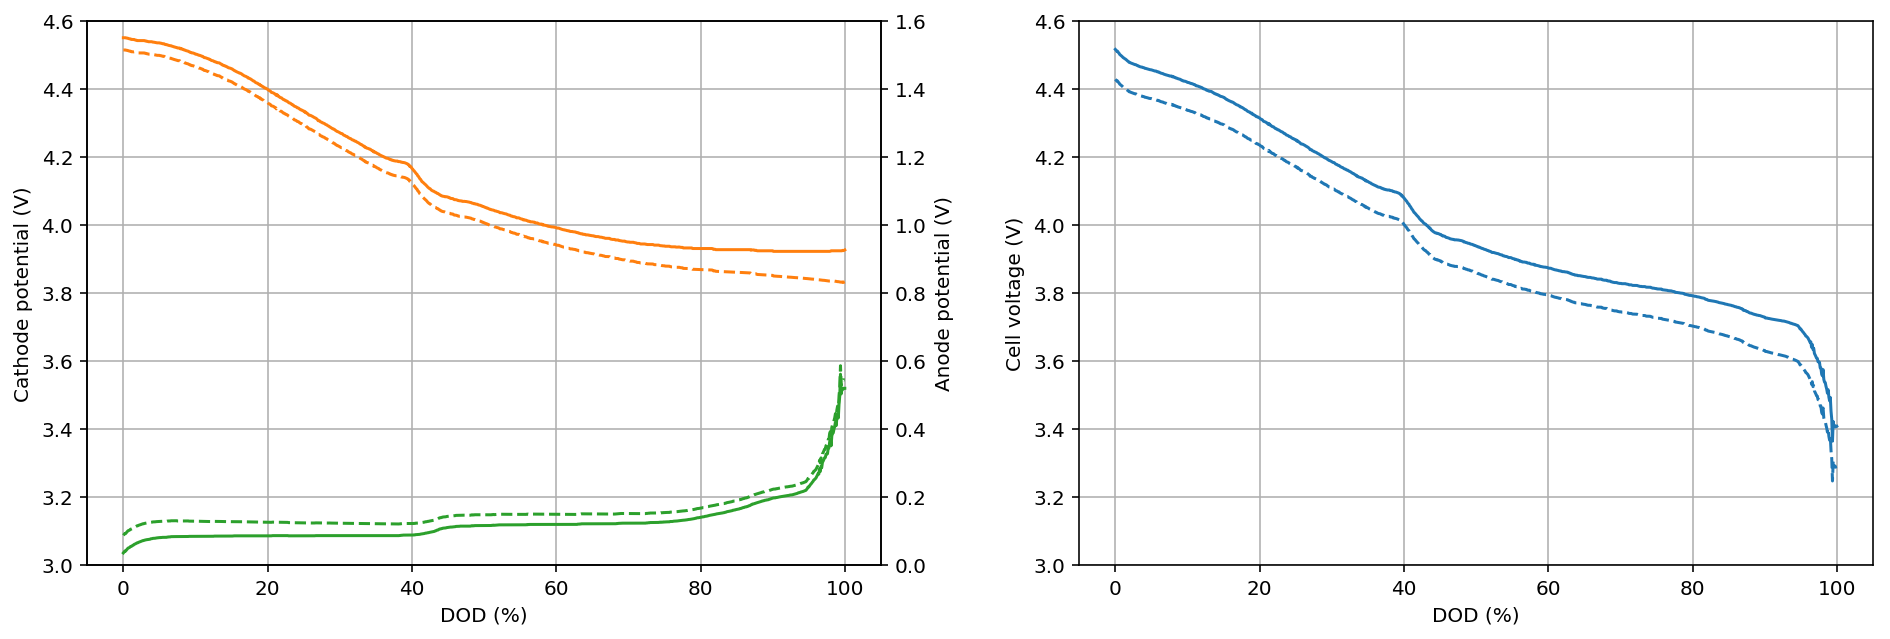

In [86]:
fig, (ax1,ax3) = plt.subplots(1,2,figsize=(16, 5))
plt.subplots_adjust(wspace=0.25)
ax2 = ax1.twinx()
ax1.plot(df_cell['DOD'], df_cell['Cathode OCV (V)'], color = new_colors[1])
ax1.plot(df_cell['DOD'], df_cell['Cathode CCV (V)'],'--', color = new_colors[1])
ax1.set_ylabel('Cathode potential (V)')
ax2.plot(df_cell['DOD'], df_cell['Anode OCV (V)'], color = new_colors[2])
ax2.plot(df_cell['DOD'], df_cell['Anode CCV (V)'],'--', color = new_colors[2])
ax2.set_ylabel('Anode potential (V)')
ax1.set_xlabel('DOD (%)')

ax1.set_ylim([3, 4.6])
ax2.set_ylim([0, 1.6])

ax1.grid()



ax3.plot(df_cell['DOD'], df_cell['Cell OCV (V)'], color = new_colors[0])
ax3.plot(df_cell['DOD'], df_cell['Cell CCV (V)'],'--', color = new_colors[0])
ax3.set_ylabel('Cell voltage (V)')
ax3.set_xlabel('DOD (%)')
ax3.set_ylim([3, 4.6])

ax3.grid()

plt.show()



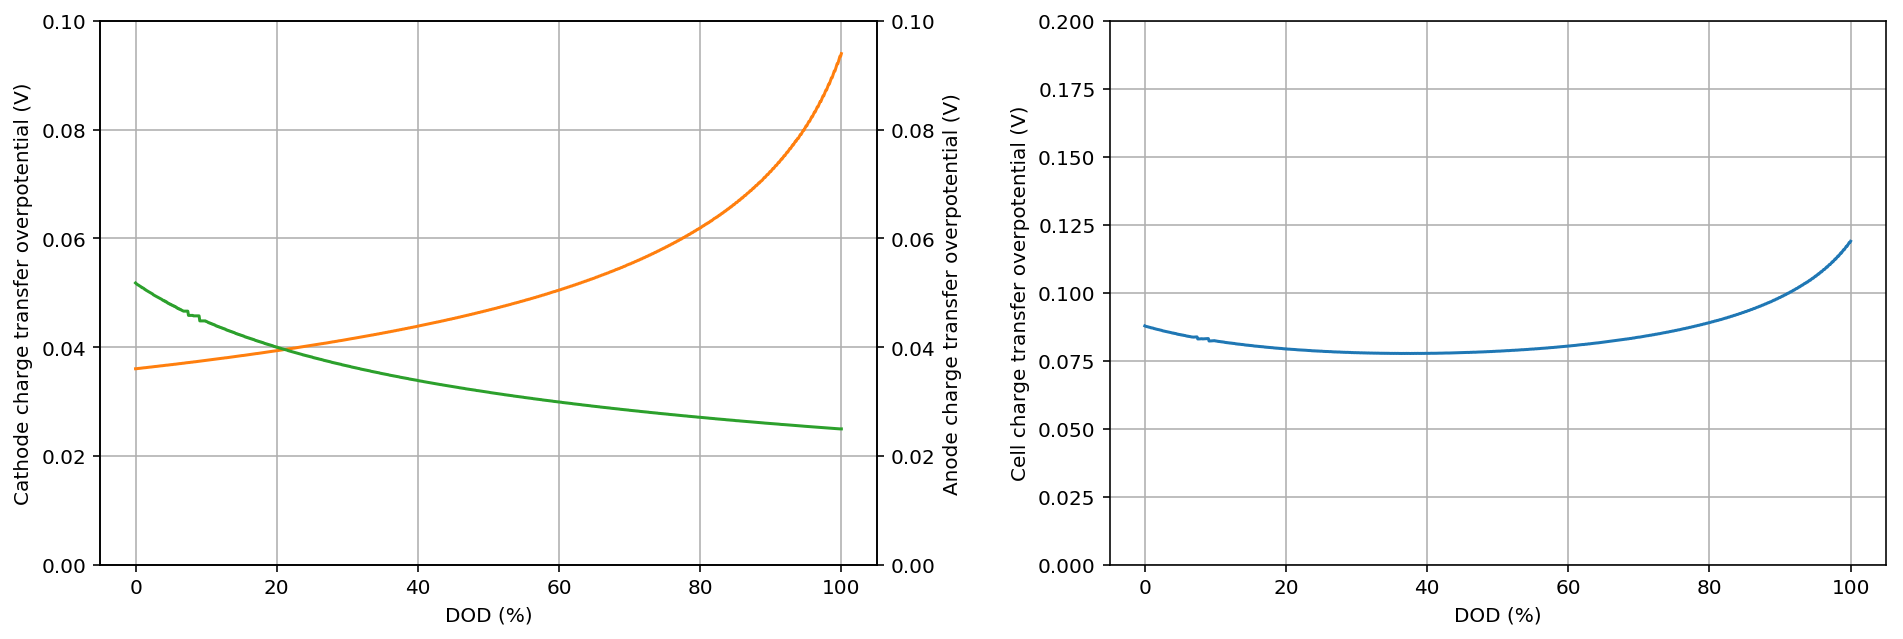

In [87]:
fig, (ax1,ax3) = plt.subplots(1,2,figsize=(16, 5))
plt.subplots_adjust(wspace=0.3)
ax2 = ax1.twinx()
ax1.plot(df_cell['DOD'], df_cell['DV_eta_p'], color = new_colors[1])
ax1.set_ylabel('Cathode charge transfer overpotential (V)')
ax2.plot(df_cell['DOD'], df_cell['DV_eta_n'], color = new_colors[2])
ax2.set_ylabel('Anode charge transfer overpotential (V)')
ax1.set_xlabel('DOD (%)')

ax1.set_ylim([0, 0.1])
ax2.set_ylim([0, 0.1])

ax1.grid()


ax3.plot(df_cell['DOD'], df_cell['DV_eta_p']+df_cell['DV_eta_n'], color = new_colors[0])
ax3.set_ylabel('Cell charge transfer overpotential (V)')
ax3.set_xlabel('DOD (%)')
ax3.set_ylim([0, 0.2])

ax3.grid()

plt.show()


